# Credit Card Fraud Detection System

### 1. Loading dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !! Increase jupyter memory limit
import resource

# Convert 6GB to bytes
memory_limit = 6 * 1024 * 1024 * 1024

# Set the memory limit
resource.setrlimit(resource.RLIMIT_DATA, (memory_limit, memory_limit))

In [2]:
transactions = pd.read_csv('transactions.csv', index_col=0)
transactions.head()

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD
TRANSACTION_ID,,,,,,,
0,2018-04-01 00:00:31,596,3156,57.16,31,0,0
1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0
2,2018-04-01 00:07:56,2,1365,146.00,476,0,0
3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0
4,2018-04-01 00:10:34,927,9906,50.99,634,0,0


In [3]:
print(transactions.shape)
print(f'Missing values: {transactions.isnull().sum().sum()}')
print(transactions.columns)

(1754155, 7)
Missing values: 0
Index(['TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT',
       'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD'],
      dtype='object')


There are 8 features and 1754155 transactions and we have no missing values.

Number of fraudulent transactions:

In [4]:
transactions.TX_FRAUD.sum()

14681

Percentage of fraudulent transactions:

In [5]:
print(f'{round(transactions.TX_FRAUD.mean(),3) * 100}%')

0.8%


14681 transactions were marked as fraudulent, which represents only 0.8% of the total 1754155.

The dataset is very imbalanced.

### 2. Feature engineering

The dataset contains 3 categorical columns which I need to transform into relevant numerical data.

`TX_DATETIME` is the obvious one as it's not numerical.

`CUSTOMER_ID` and `TERMINAL_ID` are also categorical, even though they are numerical, they are not ordered. It wouldn't make sense to say that customer number 1 is 'greater' or 'less' than customer number 2.

In [6]:
categorical_cols = ['TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID']
transactions[categorical_cols]

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID
TRANSACTION_ID,,,
0,2018-04-01 00:00:31,596,3156
1,2018-04-01 00:02:10,4961,3412
2,2018-04-01 00:07:56,2,1365
3,2018-04-01 00:09:29,4128,8737
4,2018-04-01 00:10:34,927,9906
...,...,...,...
1754150,2018-09-30 23:56:36,161,655
1754151,2018-09-30 23:57:38,4342,6181
1754152,2018-09-30 23:58:21,618,1502


Extracting useful features from `TX_DATETIME`:
  - `TX_NIGHT` - whether the transaction was done during the night (between 00:00 and 06:00)

This *may* be a relevant predictor as it's possible more fraudulent transactions occur at nighttime.

In [7]:
def is_night(tx_datetime):
    tx_hour = tx_datetime.hour
    # if hour is between 0 and 6 => nighttime

    return int(0 <= tx_hour <= 6)

In [8]:
# cast `TX_DATETIME` to pandas datetime data type (it was object before)
transactions['TX_DATETIME'] = pd.to_datetime(transactions['TX_DATETIME'])

In [9]:
transactions['TX_NIGHT'] = transactions.TX_DATETIME.apply(is_night)

  - `TX_WEEKEND` - whether the transaction was done during the weekend (Saturday/Sunday)

In [10]:
def is_weekend(tx_datetime):
    # this will return the number of the weekday (0...6)
    # we are only interested in 5 and 6 e.g. Saturday/Sunday
    weekday_no = tx_datetime.weekday()

    return int(weekday_no >= 5)

In [11]:
transactions['TX_WEEKEND'] = transactions.TX_DATETIME.apply(is_weekend)

In [12]:
# checking if the cols were correctly added
transactions[transactions.TX_TIME_DAYS>=8]

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_NIGHT,TX_WEEKEND
TRANSACTION_ID,,,,,,,,,
76444,2018-04-09 00:02:37,3268,413,98.87,691357,8,0,1,0
76445,2018-04-09 00:03:23,2075,672,71.43,691403,8,0,1,0
76446,2018-04-09 00:03:31,4158,7573,7.89,691411,8,0,1,0
76447,2018-04-09 00:03:54,531,9453,32.70,691434,8,0,1,0
76448,2018-04-09 00:04:05,2274,5089,11.10,691445,8,0,1,0
...,...,...,...,...,...,...,...,...,...
1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,1
1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1
1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,1



Extracting useful features from `CUSTOMER_ID`:
  - `CUSTOMER_N_TX_LAST_{n}_DAYS` - the number of transactions this customer has made in the last n days. n is arbitrarily chosen as {1, 7, 30}
  - `CUSTOMER_AVG_SPENDING_LAST_{n}_DAYS` - average spending amount by this customer in the last {1, 7, 30} days
  
If a fraudster steals a credit card, he will try to make as many expensive transactions as possible before the card is flagged as stolen, which will conflict with the customer's regular spending habits.

In total, we will be ading 8 new features.


*These aggregated features will be trickier to compute.*


I will use the Pandas `.rolling()` function which provides rolling window calculations.

Let's first define a function to get the spending behaviours of one customer:

In [13]:
def get_customer_spending_behaviour(customer_transactions: pd.DataFrame):
    # customer_transactions contains only rows of transactions of the given customer
    # sort transactions chronologically:
    customer_transactions = customer_transactions.sort_values('TX_DATETIME')
    # need to set index as TX_DATETIME to use the rolling function
    oldindex = customer_transactions.index
    customer_transactions.index = customer_transactions.TX_DATETIME

    for window in [1, 7, 30]:
        N_TX_WINDOW = customer_transactions['TX_AMOUNT'].rolling(f'{window}d').count()
        SUM_AMOUNT_TX_WINDOW = customer_transactions['TX_AMOUNT'].rolling(f'{window}d').sum()

        AVG_SPENDING_WINDOW = SUM_AMOUNT_TX_WINDOW / N_TX_WINDOW

        # save features
        customer_transactions[f'CUSTOMER_N_TX_LAST_{window}_DAYS'] = list(N_TX_WINDOW)
        customer_transactions[f'CUSTOMER_AVG_SPENDING_LAST_{window}_DAYS'] = list(AVG_SPENDING_WINDOW)
    
    # put back original index
    customer_transactions.index = oldindex
    
    return customer_transactions

Let's try this function on the first customer.

In [14]:
spending_behav_first_customer = get_customer_spending_behaviour(transactions[transactions.CUSTOMER_ID == 0])
spending_behav_first_customer

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_NIGHT,TX_WEEKEND,CUSTOMER_N_TX_LAST_1_DAYS,CUSTOMER_AVG_SPENDING_LAST_1_DAYS,CUSTOMER_N_TX_LAST_7_DAYS,CUSTOMER_AVG_SPENDING_LAST_7_DAYS,CUSTOMER_N_TX_LAST_30_DAYS,CUSTOMER_AVG_SPENDING_LAST_30_DAYS
TRANSACTION_ID,,,,,,,,,,,,,,,
1758,2018-04-01 07:19:05,0,6076,123.59,26345,0,0,0,1,1.0,123.590000,1.0,123.590000,1.0,123.590000
8275,2018-04-01 18:00:16,0,858,77.34,64816,0,0,0,1,2.0,100.465000,2.0,100.465000,2.0,100.465000
8640,2018-04-01 19:02:02,0,6698,46.51,68522,0,0,0,1,3.0,82.480000,3.0,82.480000,3.0,82.480000
12169,2018-04-02 08:51:06,0,6569,54.72,118266,1,0,0,0,3.0,59.523333,4.0,75.540000,4.0,75.540000
15764,2018-04-02 14:05:38,0,7707,63.30,137138,1,0,0,0,4.0,60.467500,5.0,73.092000,5.0,73.092000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750390,2018-09-30 13:38:41,0,3096,38.23,15773921,182,0,0,1,5.0,64.388000,28.0,57.306429,89.0,63.097640
1750758,2018-09-30 14:10:21,0,9441,43.60,15775821,182,0,0,1,6.0,60.923333,29.0,56.833793,89.0,62.433933
1751039,2018-09-30 14:34:30,0,1138,69.69,15777270,182,0,0,1,7.0,62.175714,29.0,57.872414,90.0,62.514556


This looks good. Let's apply it to all customers using pandas `groupby` combined with `apply`.

In [15]:
transactions = transactions.groupby('CUSTOMER_ID').apply(get_customer_spending_behaviour)
# need to reset index because the previous command generated a double index with CUSTOMER_ID
transactions = transactions.sort_values('TX_DATETIME').reset_index(drop=True)

In [16]:
transactions

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_NIGHT,TX_WEEKEND,CUSTOMER_N_TX_LAST_1_DAYS,CUSTOMER_AVG_SPENDING_LAST_1_DAYS,CUSTOMER_N_TX_LAST_7_DAYS,CUSTOMER_AVG_SPENDING_LAST_7_DAYS,CUSTOMER_N_TX_LAST_30_DAYS,CUSTOMER_AVG_SPENDING_LAST_30_DAYS
0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,1,1,1.0,57.160000,1.0,57.160000,1.0,57.160000
1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,1,1,1.0,81.510000,1.0,81.510000,1.0,81.510000
2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,1,1,1.0,146.000000,1.0,146.000000,1.0,146.000000
3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,1,1,1.0,64.490000,1.0,64.490000,1.0,64.490000
4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,1,1,1.0,50.990000,1.0,50.990000,1.0,50.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,1,2.0,75.280000,12.0,67.047500,72.0,69.521111
1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1,1.0,1.230000,21.0,22.173810,93.0,24.780753
1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,1,5.0,7.368000,21.0,7.400476,65.0,7.864462
1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0,1,3.0,100.696667,16.0,107.052500,51.0,102.919608


Extracting useful features from `TERMINAL_ID`:
  - `TERMINAL_N_TX_LAST_{n}_DAYS` - the number of transactions made on this terminal in the last $n$ days, $n \in \{1,7,30\}$ and $d=7$ (explained below)
  - `TERMINAL_RISK_SCORE_LAST_{n}_DAYS` - average number of frauds on this terminal in the last $n+d$ days, $n \in \{1,7,30\}$ and $d=7$

These time windows do not immediately precede a given transaction, instead they are shifted back by a delay period $d$.

This is because, in practice, fraudulent transactions aren't labelled as such until a customer complains about it, or a fraud is discovered through an investigation. As the risk score is computed using the fraud label, which can only be known after a certain delay period, this time window should be shifted by that delay period $d$. For this example, $d=7$.


In [17]:
# terminal_transactions param is the dataframe of transactions for a given terminal id

def get_terminal_risk(terminal_transactions: pd.DataFrame):
    DELAY_PERIOD=7
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    oldindex = terminal_transactions.index
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    # compute rolling sums of frauds for delay period only
    N_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(DELAY_PERIOD)+'d').sum()
    N_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(DELAY_PERIOD)+'d').count()
    
    for window_size in [1, 7, 30]:
        # compute rolling sums of frauds for delay period + each window size
        N_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(DELAY_PERIOD+window_size)+'d').sum()
        N_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(DELAY_PERIOD+window_size)+'d').count()
    

        # the rolling sum for just the window is now the rolling sum for the delay with window minus the rolling sum for the delay
        N_FRAUD_WINDOW=N_FRAUD_DELAY_WINDOW-N_FRAUD_DELAY
        N_TX_WINDOW=N_TX_DELAY_WINDOW-N_TX_DELAY
    
        RISK_WINDOW=N_FRAUD_WINDOW/N_TX_WINDOW
        
        terminal_transactions['TERMINAL_N_TX_LAST_'+str(window_size)+'_DAYS']=list(N_TX_WINDOW)
        terminal_transactions['TERMINAL_RISK_SCORE_LAST_'+str(window_size)+'_DAYS']=list(RISK_WINDOW)
        
    terminal_transactions.index=oldindex


    # Replace NA values with 0 (all undefined risk scores where N_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

Let's try this function on the first terminal containing a fraudulent transaction.

In [18]:
# Get the first terminal ID that contains frauds
fraud_terminals = transactions[transactions.TX_FRAUD==1].TERMINAL_ID
fraud_terminals.iloc[0]

3059

In [19]:
get_terminal_risk(transactions[transactions.TERMINAL_ID==3059])

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_NIGHT,TX_WEEKEND,CUSTOMER_N_TX_LAST_1_DAYS,...,CUSTOMER_N_TX_LAST_7_DAYS,CUSTOMER_AVG_SPENDING_LAST_7_DAYS,CUSTOMER_N_TX_LAST_30_DAYS,CUSTOMER_AVG_SPENDING_LAST_30_DAYS,TERMINAL_N_TX_LAST_1_DAYS,TERMINAL_RISK_SCORE_LAST_1_DAYS,TERMINAL_N_TX_LAST_7_DAYS,TERMINAL_RISK_SCORE_LAST_7_DAYS,TERMINAL_N_TX_LAST_30_DAYS,TERMINAL_RISK_SCORE_LAST_30_DAYS
3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,0,1,3.0,...,3.0,158.073333,3.0,158.073333,0.0,0.0,0.0,0.0,0.0,0.0
4732,2018-04-01 11:59:14,55,3059,36.28,43154,0,0,0,1,2.0,...,2.0,35.670000,2.0,35.670000,0.0,0.0,0.0,0.0,0.0,0.0
16216,2018-04-02 14:47:34,4879,3059,105.00,139654,1,0,0,0,4.0,...,10.0,76.010000,10.0,76.010000,0.0,0.0,0.0,0.0,0.0,0.0
18249,2018-04-02 19:08:10,2263,3059,90.89,155290,1,0,0,0,3.0,...,7.0,50.458571,7.0,50.458571,0.0,0.0,0.0,0.0,0.0,0.0
26512,2018-04-03 15:44:49,4879,3059,58.51,229489,2,0,0,0,3.0,...,14.0,71.070000,14.0,71.070000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697944,2018-09-25 05:32:56,402,3059,57.30,15312776,177,0,1,0,3.0,...,14.0,65.167857,46.0,68.163261,1.0,0.0,9.0,0.0,36.0,0.0
1701971,2018-09-25 12:30:54,1035,3059,7.56,15337854,177,0,0,0,4.0,...,23.0,7.052174,107.0,6.763738,2.0,0.0,10.0,0.0,36.0,0.0
1704512,2018-09-25 16:37:41,1519,3059,35.79,15352661,177,0,0,0,3.0,...,7.0,41.404286,30.0,46.780000,1.0,0.0,9.0,0.0,36.0,0.0
1731937,2018-09-28 14:30:31,1534,3059,81.39,15604231,180,0,0,0,3.0,...,18.0,69.477778,89.0,63.906629,1.0,0.0,8.0,0.0,36.0,0.0


This looks good. Let's apply it to all terminals using pandas `groupby` combined with `apply`.

In [20]:
transactions = transactions.groupby('TERMINAL_ID').apply(get_terminal_risk)
# need to reset index because the previous command generated a double index with TERMINAL_ID
transactions = transactions.sort_values('TX_DATETIME').reset_index(drop=True)

In [21]:
transactions

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_NIGHT,TX_WEEKEND,CUSTOMER_N_TX_LAST_1_DAYS,...,CUSTOMER_N_TX_LAST_7_DAYS,CUSTOMER_AVG_SPENDING_LAST_7_DAYS,CUSTOMER_N_TX_LAST_30_DAYS,CUSTOMER_AVG_SPENDING_LAST_30_DAYS,TERMINAL_N_TX_LAST_1_DAYS,TERMINAL_RISK_SCORE_LAST_1_DAYS,TERMINAL_N_TX_LAST_7_DAYS,TERMINAL_RISK_SCORE_LAST_7_DAYS,TERMINAL_N_TX_LAST_30_DAYS,TERMINAL_RISK_SCORE_LAST_30_DAYS
0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,1,1,1.0,...,1.0,57.160000,1.0,57.160000,0.0,0.0,0.0,0.0,0.0,0.00000
1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,1,1,1.0,...,1.0,81.510000,1.0,81.510000,0.0,0.0,0.0,0.0,0.0,0.00000
2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,1,1,1.0,...,1.0,146.000000,1.0,146.000000,0.0,0.0,0.0,0.0,0.0,0.00000
3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,1,1,1.0,...,1.0,64.490000,1.0,64.490000,0.0,0.0,0.0,0.0,0.0,0.00000
4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,1,1,1.0,...,1.0,50.990000,1.0,50.990000,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,1,2.0,...,12.0,67.047500,72.0,69.521111,1.0,0.0,4.0,0.0,28.0,0.00000
1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1,1.0,...,21.0,22.173810,93.0,24.780753,1.0,0.0,9.0,0.0,39.0,0.00000
1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,1,5.0,...,21.0,7.400476,65.0,7.864462,1.0,0.0,5.0,0.0,33.0,0.00000
1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0,1,3.0,...,16.0,107.052500,51.0,102.919608,1.0,0.0,6.0,0.0,28.0,0.00000


### 3. Training the initial model

#### a) Choosing train/test sets

For the initial model, I will use a fraction of the full dataset to train and test it.

I will be using one week of the transactions for training, and a different week for testing. These will be in chronological order.

To simulate a real world scenario, there should also be a delay period between the 2 weeks. It accounts for the fact that transactions aren't known to have been fraudulent until they are reported as such, i.e., the label of a transaction (the target variable for our model: fraudulent/genuine) isn't known until a customer files a complaint, or a fraud investigation takes place.

In other words, the data used to train a model and make predictions for a specific day `X` must chronologically precede the day `X` by an amount equivalent to the delay period required for setting the values of the target variables.

I will choose the delay period to be one week. I am assuming that it always takes one week to establish whether a transaction was genuine or not.

Therefore, 
- the training set will be the week commencing 2018-07-25 and ending 2018-07-31
- the test set will be week 2018-08-08 - 2018-08-14

In [22]:
import datetime

def train_test_set(transactions: pd.DataFrame, start_date_training: datetime.datetime, sampling_ratio=1.0, random_state=0):
    # the length of the training period, length of delay period, length of test period
    DELTA_TRAIN = DELTA_DELAY = DELTA_TEST = 7

    train_set = transactions[(start_date_training <= transactions.TX_DATETIME) & (transactions.TX_DATETIME < start_date_training + datetime.timedelta(days=DELTA_TRAIN))]

    start_date_test = start_date_training + datetime.timedelta(days=DELTA_TRAIN) + datetime.timedelta(days=DELTA_DELAY)
    test_set = transactions[(start_date_test <= transactions.TX_DATETIME) & (transactions.TX_DATETIME < start_date_test + datetime.timedelta(days=DELTA_TEST))]

     # If subsample
    if sampling_ratio < 1:
        train_frauds=train_set[train_set.TX_FRAUD==1].sample(frac=sampling_ratio, random_state=random_state)
        train_genuine=train_set[train_set.TX_FRAUD==0].sample(frac=sampling_ratio, random_state=random_state)
        train_set=pd.concat([train_frauds,train_genuine], axis=0)
        
    # Sort data sets by ascending order of transaction ID
    train_set=train_set.sort_index()
    test_set=test_set.sort_index()

    return (train_set, test_set)

In [23]:
transactions.shape

(1754155, 21)

In [24]:
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
(train_set, test_set) = train_test_set(transactions, start_date_training)
train_set.shape

(67240, 21)

In [25]:
train_set[train_set.TX_FRAUD == 1].shape

(598, 21)

In [26]:
test_set.shape

(67080, 21)

In [27]:
test_set[test_set.TX_FRAUD == 1].shape

(568, 21)

In [28]:
print(f'Percent fradulent transactions train set: {round(598/67240 * 100, 4)}%')
print(f'Percent fradulent transactions test set: {round(568/67080 * 100, 4)}%')

Percent fradulent transactions train set: 0.8894%
Percent fradulent transactions test set: 0.8468%


The train set contains 67240 transactions, of which 598 are fraudulent. (0.88%)

The test set contains 67080 transactions, of which 568 are fraudulent. (0.84%)

#### b) Training simple model: Decision Tree

Separating the input/output features as follows:
- input (predictor variables): `TX_AMOUNT`, `TX_NIGHT`, `TX_WEEKEND`, `CUSTOMER_N_TX_LAST_1_DAYS`, `CUSTOMER_AVG_SPENDING_LAST_1_DAYS`, `CUSTOMER_N_TX_LAST_7_DAYS`, `CUSTOMER_AVG_SPENDING_LAST_7_DAYS`, `CUSTOMER_N_TX_LAST_30_DAYS`, `CUSTOMER_AVG_SPENDING_LAST_30_DAYS`, `TERMINAL_N_TX_LAST_1_DAYS`, `TERMINAL_N_TX_LAST_7_DAYS`, `TERMINAL_N_TX_LAST_30_DAYS`, `TERMINAL_RISK_SCORE_LAST_1_DAYS`, `TERMINAL_RISK_SCORE_LAST_7_DAYS`, `TERMINAL_RISK_SCORE_LAST_30_DAYS`
- output (target variable): `TX_FRAUD`

Let's define a function that trains and tests a given classifier (model) and outputs the results along with the training and prediction times.

In [29]:
features = ['TX_AMOUNT', 'TX_NIGHT', 'TX_WEEKEND', 'CUSTOMER_N_TX_LAST_1_DAYS', 'CUSTOMER_AVG_SPENDING_LAST_1_DAYS', 'CUSTOMER_N_TX_LAST_7_DAYS', 'CUSTOMER_AVG_SPENDING_LAST_7_DAYS', 'CUSTOMER_N_TX_LAST_30_DAYS', 'CUSTOMER_AVG_SPENDING_LAST_30_DAYS',
            'TERMINAL_N_TX_LAST_1_DAYS', 'TERMINAL_N_TX_LAST_7_DAYS', 'TERMINAL_N_TX_LAST_30_DAYS', 'TERMINAL_RISK_SCORE_LAST_1_DAYS', 'TERMINAL_RISK_SCORE_LAST_7_DAYS', 'TERMINAL_RISK_SCORE_LAST_30_DAYS']

def fit_model_and_get_preds(classifier, train_set, test_set):
  y_train = train_set.TX_FRAUD
  y_test = test_set.TX_FRAUD


  X_train = train_set[features]
  X_test = test_set[features]

  classifier.fit(X_train, y_train)

  # predict_proba() will return 2 numbers:
  # - the probability that this transaction is NOT a fraud
  # - the probability that this transaction is a fraud
  # we are interested in the last element
  predictions_train = classifier.predict_proba(X_train)[:,-1]
  predictions_test = classifier.predict_proba(X_test)[:,-1]


  model_and_predictions_dict = {'classifier': classifier,
                                'predictions_train': predictions_train,
                                'predictions_test': predictions_test
                              }

  return model_and_predictions_dict

For the first model, let's use a DecisionTreeClassifier, limited to a max_depth of 2 for simplicity.

In [30]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth=2, random_state=0)

model_and_predictions_dict = fit_model_and_get_preds(classifier, train_set=train_set, test_set=test_set)

In [31]:
import warnings
warnings.filterwarnings('ignore')
test_set['TX_FRAUD_PREDICTED'] = model_and_predictions_dict['predictions_test']
warnings.filterwarnings('default')
test_set.head()

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_NIGHT,TX_WEEKEND,CUSTOMER_N_TX_LAST_1_DAYS,...,CUSTOMER_AVG_SPENDING_LAST_7_DAYS,CUSTOMER_N_TX_LAST_30_DAYS,CUSTOMER_AVG_SPENDING_LAST_30_DAYS,TERMINAL_N_TX_LAST_1_DAYS,TERMINAL_RISK_SCORE_LAST_1_DAYS,TERMINAL_N_TX_LAST_7_DAYS,TERMINAL_RISK_SCORE_LAST_7_DAYS,TERMINAL_N_TX_LAST_30_DAYS,TERMINAL_RISK_SCORE_LAST_30_DAYS,TX_FRAUD_PREDICTED
1236698,2018-08-08 00:01:14,2765,2747,42.32,11145674,129,0,1,0,4.0,...,67.468529,120.0,64.611750,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
1236699,2018-08-08 00:02:33,714,2073,108.19,11145753,129,0,1,0,8.0,...,79.955455,124.0,85.365645,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
1236700,2018-08-08 00:06:00,1196,421,15.41,11145960,129,0,1,0,7.0,...,10.449565,99.0,11.614343,4.0,0.0,9.0,0.0,27.0,0.000000,0.003536
1236701,2018-08-08 00:08:40,4982,1258,26.13,11146120,129,0,1,0,1.0,...,56.269167,61.0,49.095902,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
1236702,2018-08-08 00:08:41,704,8501,65.81,11146121,129,0,1,0,1.0,...,62.643333,11.0,63.287273,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536


This shows that the first 5 transactions have a probability of being frauds of 0.35%.

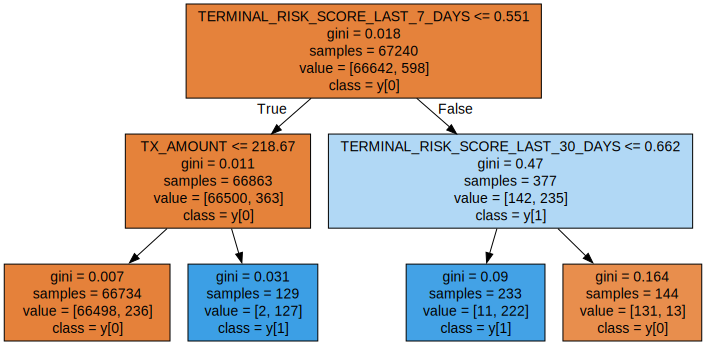

In [32]:
from sklearn.tree import export_graphviz
import graphviz

display(graphviz.Source(export_graphviz(classifier, feature_names=features,class_names=True, filled=True)))

This simple model classifies all transactions with a `TX_AMOUNT` larger than 219 as fraudulent, and the rest as genuine.

All of the five first transactions printed above fall into the first leaf, a leaf that contains 236 fraudulent transactions and 66498 genuine transactions. Therefore, this leaf has a probability of fraud of $\frac{236}{236+66498} = 0.003536428208 = 0.35\%$

Let's fit and test some other standard models so we can evaluate their perfomances and choose the best one.

I will be fitting the following models:
- Decision Tree of depth 2
- Decision Tree of depth 6
- Decision Tree of unlimited depth
- Random Forest
- Logistic Regression
- XGBoost Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

classifiers = {'Decision Tree depth 2': DecisionTreeClassifier(max_depth=2, random_state=0),
               'Decision Tree depth 6': DecisionTreeClassifier(max_depth=6, random_state=0),
               'Decision Tree depth unlimited': DecisionTreeClassifier(random_state=0),
               'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1),
               'Logistic Regression': LogisticRegression(random_state=0),
               'XGBoost': XGBClassifier(random_state=0, n_jobs=-1),
               }

fitted_models_and_preds = {}


warnings.filterwarnings('ignore')
for classifier_name in classifiers:
    predictions = fit_model_and_get_preds(classifiers[classifier_name], train_set, test_set)

    fitted_models_and_preds[classifier_name] = predictions
warnings.filterwarnings('default')

#### c) Evaluating performance

Metrics to compute:
1. Accuracy - not really a good metric given how imbalanced the dataset it
$$ Accuracy = \frac{TP + TN}{N} $$
2. Precision
$$ Precision = \frac{TP}{TP + FP} $$
3. Recall/Sensitivity
$$ Recall = \frac{TP}{TP + FN} $$
4. F1-score - the harmonic mean of Precision and Recall
$$ F1 = 2 * \frac{Precision * Recall}{Precision + Recall} $$
5. Average Precision Score - AP: summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight
$$ AP = \sum_{n} (R_{n} - R_{n-1})P_{n} $$
6. Area Under the Receiver Operating Characteristic Curve - AUC ROC
= The probability that a randomly selected *positive* (fraudulent) example has a higher predicted probability of being positive, than a randomly selected negative example. It is calculated as the area underneath a curve that measures the trade off between True Positive Rate (TPR/Recall) and False Positive Rate (FPR) at different thresholds.


In [34]:
# Getting classes from a vector of fraud probabilities and a threshold
def get_class_from_fraud_probability(fraud_probabilities, threshold=0.5):
    predicted_classes = [0 if fraud_probability < threshold else 1 
                         for fraud_probability in fraud_probabilities]

    return predicted_classes

In [35]:
from sklearn.metrics import accuracy_score, average_precision_score, precision_score, recall_score, f1_score, roc_auc_score

def performance_evaluation(predictions_df, all=True):
    OUTPUT_FEATURE = 'TX_FRAUD'
    PREDICTION_FEATURE = 'predictions'
    PREDICTION_PROBA_FEATURE = 'predictions_proba'

    if all:
        accuracy = accuracy_score(predictions_df[OUTPUT_FEATURE], predictions_df[PREDICTION_FEATURE])
        precision = precision_score(predictions_df[OUTPUT_FEATURE], predictions_df[PREDICTION_FEATURE])
        recall = recall_score(predictions_df[OUTPUT_FEATURE], predictions_df[PREDICTION_FEATURE])
        f1 = f1_score(predictions_df[OUTPUT_FEATURE], predictions_df[PREDICTION_FEATURE])

    ap = average_precision_score(predictions_df[OUTPUT_FEATURE], predictions_df[PREDICTION_PROBA_FEATURE])
    auc_roc = roc_auc_score(predictions_df[OUTPUT_FEATURE], predictions_df[PREDICTION_PROBA_FEATURE])

    if all:
        performances = pd.DataFrame([[accuracy, precision, recall, f1, ap, auc_roc]], 
                            columns=['Accuracy','Precision', 'Recall', 'F1', 'Average precision', 'AUC ROC'])
    else:
        performances = pd.DataFrame([[ap, auc_roc]], 
                            columns=['Average precision', 'AUC ROC'])

    

    return performances.round(3)


def performance_evaluation_for_model_collection(fitted_models_and_preds, transactions: pd.DataFrame, type_set='test'):
    performances = pd.DataFrame()

    for classifier_name, model_predictions in fitted_models_and_preds.items():
        predictions_df = transactions.copy()
        predictions_df.insert(0, "predictions", get_class_from_fraud_probability(model_predictions['predictions_' + type_set]))
        predictions_df.insert(0, "predictions_proba", model_predictions['predictions_' + type_set])

        performances_of_this_model = performance_evaluation(predictions_df)
        performances_of_this_model.index = [classifier_name]

        performances = pd.concat([performances,performances_of_this_model])

    return performances

**Performance on the test set**:

In [36]:
performances_test = performance_evaluation_for_model_collection(fitted_models_and_preds, test_set)

performances_test

,Accuracy,Precision,Recall,F1,Average precision,AUC ROC
Decision Tree depth 2,0.996,0.980,0.530,0.688,0.561,0.793
Decision Tree depth 6,0.996,0.960,0.556,0.705,0.637,0.837
Decision Tree depth unlimited,0.993,0.574,0.618,0.595,0.358,0.807
Random Forest,0.996,0.978,0.556,0.709,0.719,0.894
Logistic Regression,0.993,0.703,0.391,0.502,0.490,0.878
XGBoost,0.996,0.963,0.593,0.734,0.703,0.892


**Performance on the train set**:

In [37]:
performances_train = performance_evaluation_for_model_collection(fitted_models_and_preds, train_set, type_set='train')

performances_train

,Accuracy,Precision,Recall,F1,Average precision,AUC ROC
Decision Tree depth 2,0.996,0.964,0.584,0.727,0.586,0.802
Decision Tree depth 6,0.996,0.981,0.617,0.758,0.662,0.842
Decision Tree depth unlimited,1.000,1.000,1.000,1.000,1.000,1.000
Random Forest,1.000,1.000,0.998,0.999,1.000,1.000
Logistic Regression,0.993,0.723,0.428,0.538,0.531,0.882
XGBoost,0.999,1.000,0.886,0.940,0.995,1.000


##### **Accuracy**
Even though the accuracy is 99% for the test set, this is not a good metric for such an imbalanced dataset.

Remember that less than 1% of the test set were fraudulent transactions. Even a classifier that just said "genuine" to all transactions would have an accuracy of 99%! - this proves that this metric isn't good for assessing a classifier's performance

##### **Precision/Recall**
Regarding the recall, it is decent in the test_set, reaching it's highest of 61% in the unlimited depth Decision Tree. It even gets to 100% in the training set for the Decison tree of unlimited depth. The same goes for the mediocre testing precision in the case of this same model (57%), but high precision on the train set. This is a case of **overfitting**, where a model fits too tightly to the training set, but fails to generalise on unseen data.

##### **F1 Score**
Unsurprisingly, the F1 score reaches its highest value of 73% on the test set in the case of the gradient boosted model.

##### **Average Precision**
Average precision is a good performance indicator because it tries to remove the dependency of selecting one confidence threshold value. It is defined as the Area under the Precision-Recall curve.
The models with the best AP scores are Random Forest and XGBoost, while the worst are unlimited Decision Trees and Logistic Regression.

It is worth noting that a random model will always achieve an AP of 0.8468% on the test set (the percentage of fraudulent transactions). It is clear that the AP produced by Random Forest and XGBoost which are of 70%, 72% are a significant improvement and these models don't just make random predictions (they're actually really good predictions!).

##### **AUC ROC**
AUC ROC is also a good indicator as it is also classification-threshold-invariant, measuring the quality of the model's predictions irrespective of what classification threshold is chosen.

A random classifier would give an AUC ROC of 50%, whereas our best models in this example, Random Forest and XGBoost, both have an AUC ROC of 89%, confirming their ability of making predictions that are much better than a random model.

### 4. Model validation

So far I've only partitioned the dataset into a training set and a test set. This enabled me to train the model on the training set, evaluate it on the test set, then tweak the model according to the results on the *test set*, and finally pick the model that did best on the test set.

In order to greatly reduce the chances of the model overfitting to the train/test set, I could partition the initial dataset into 3 sets: training, validation and test set.

The new workflow will be:
  - train model on training set
  - evaluate model on *validation* set
  - tweak model according to results from validation set
  - repeat training
  - pick model that did best on validation set
  - confirm performance on the previously unseen test set

This workflow is better because it creates fewer exposures to the test set.

Define a new function that synthesises everything in section 3 of this notebook, that is, given a classifier, it returns a table of metrics.

In [38]:
def get_performances(transactions: pd.DataFrame, classifier, start_date_training, type_set='Test', parameter_chosen=''):
    # split into train/test sets

    (train_set, test_set) = train_test_set(transactions, start_date_training) 

    # fit model
    model_and_predictions_dict = fit_model_and_get_preds(classifier, train_set, test_set)

    # calculate performances
    train_set.insert(0, "predictions_proba", model_and_predictions_dict['predictions_train'])
    performances_train = performance_evaluation(train_set, all=False)
    performances_train.columns = performances_train.columns.values + ' Train'
    
    test_set.insert(0, "predictions_proba", model_and_predictions_dict['predictions_test'])
    performances_test = performance_evaluation(test_set, all=False)
    performances_test.columns = performances_test.columns.values + ' ' + type_set

    performances = pd.concat([performances_test, performances_train], axis=1)
    performances['Parameter Chosen'] = parameter_chosen

    return performances

Let's try this function on a Decision three of depth 2 and confirm it produces the same results as in part 3.

In [39]:
classifier = DecisionTreeClassifier(max_depth=2, random_state=0)

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
performances = get_performances(transactions, classifier, start_date_training, parameter_chosen=2)
performances

,Average precision Test,AUC ROC Test,Average precision Train,AUC ROC Train,Parameter Chosen
0,0.561,0.793,0.586,0.802,2


Indeed it produces the same results as in part 3.

Now we can tweak the model's hyperparameter and see how the performances vary.
Let's set the Decision Tree's max_depth as numbers from 2 to 40.

In [40]:
params = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40]

performances = pd.DataFrame()

for max_depth in params:
    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=0)

    performances = pd.concat([performances, 
                              get_performances(transactions, classifier, start_date_training, parameter_chosen=max_depth)],
                              axis=0)

performances.reset_index(inplace=True, drop=True)

In [41]:
performances

,Average precision Test,AUC ROC Test,Average precision Train,AUC ROC Train,Parameter Chosen
0,0.561,0.793,0.586,0.802,2
1,0.615,0.817,0.615,0.815,3
2,0.623,0.825,0.635,0.829,4
3,0.634,0.834,0.649,0.835,5
4,0.637,0.837,0.662,0.842,6
5,0.596,0.816,0.679,0.876,7
6,0.594,0.807,0.717,0.884,8
7,0.560,0.784,0.737,0.896,9
8,0.533,0.773,0.756,0.901,10
9,0.465,0.764,0.907,0.974,20


Let's plot the results in terms of AP and AUC ROC as a function of max_depth.

In [42]:
# Get the performance plot for a single performance metric
def get_performance_plot(performances, 
                         ax, 
                         performance_metric, 
                         type_list=['Test','Train'], 
                         type_color_list=['#008000','#2F4D7E'],
                         parameter_name="Tree max_depth",
                         summary_performances: pd.DataFrame | None = None):
    
    # type_list is the list of type of experiments, typically containing 'Test', 'Train', or 'Valid'
    # For all types of experiments
    for i in range(len(type_list)):
    
        # Column in performances for which to retrieve the data 
        performance_metric_type=performance_metric+' '+type_list[i]
    
        # Plot data on graph
        ax.plot(performances['Parameter Chosen'], performances[performance_metric_type], 
                color=type_color_list[i], label = type_list[i])
        
        # If performances contains confidence intervals, add them to the graph
        if performance_metric_type+' Std' in performances.columns:
        
            conf_min = performances[performance_metric_type]\
                        -2*performances[performance_metric_type+' Std']
            conf_max = performances[performance_metric_type]\
                        +2*performances[performance_metric_type+' Std']
    
            ax.fill_between(performances['Parameter Chosen'], conf_min, conf_max, color=type_color_list[i], alpha=.1)

    # If summary_performances table is present, adds vertical dashed bar for best estimated parameter 
    if summary_performances is not None:
        # best_estimated_parameter=summary_performances[performance_metric][['Best estimated parameters ($k^*$)']].values[0]
        best_estimated_parameter = summary_performances[performance_metric].values[0]
        best_estimated_performance=float(summary_performances[performance_metric][['Validation performance']].values[0].split(" +/- ")[0])
        ymin, ymax = ax.get_ylim()
        ax.vlines(best_estimated_parameter, ymin, best_estimated_performance,
                  linestyles="dashed")
    
    # Set title, and x and y axes labels
    ax.set_title(performance_metric+'\n', fontsize=14)
    ax.set(xlabel = parameter_name, ylabel=performance_metric)

# Get the performance plots for a set of performance metric
def get_performances_plots(performances, 
                           performance_metrics_list=['AUC ROC', 'Average precision'], 
                           type_list=['Test','Train'], type_color_list=['#008000','#2F4D7E'],
                           parameter_name="Tree max_depth",
                           summary_performances=None):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_performance_plot(performances, ax[i], performance_metric=performance_metrics_list[i], 
                             type_list=type_list, 
                             type_color_list=type_color_list,
                             parameter_name=parameter_name,
                             summary_performances=summary_performances)
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=type_list, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Type set")

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

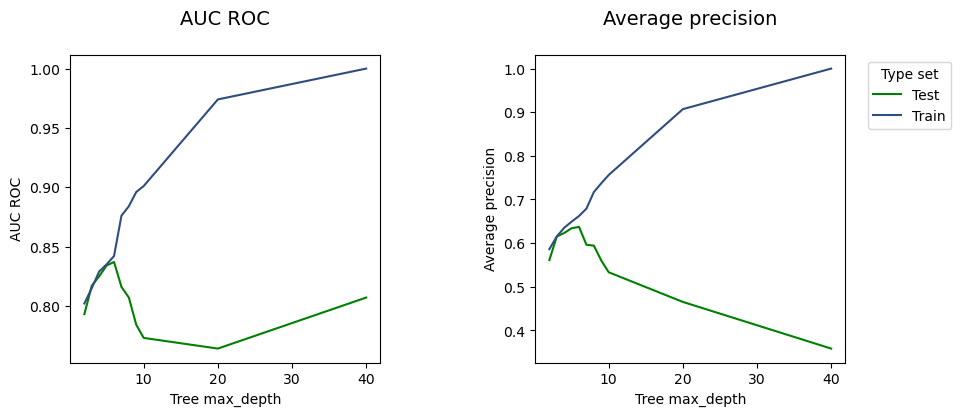

In [43]:
get_performances_plots(performances)

These graphs illustrate perfectly the overfitting phenomenon. As the depth of the trees increases, the AUC ROC and AP of the training set reach a perfect 100%, whereas the metrics of the test set get lower and lower.

Notice that the AP and AUC ROC reach their peak on the test set at a max_depth of 4, at 0.637 and 0.837 respectively. 

**A max_depth of 4 is the depth that maximises a DecisonTree's performance on the test set.**

##### >> Hold out validation

I will use hold out validation first. It means that I will be holding a part of the training set as validation. This part needs to be equal to the test set.

As I've previously made the decision of making train set and test set equal, this would be impossible. My only option is to shift back the train set by 2 weeks, choose the validation week, and then the test week. As explained before, these need to be separated by a delay period.

Therefore, the final dataset split will look like this:

      train_set - delay - valid_set - delay - test_set


Let's try this with a Decision Tree of max depth 2 again.

In [44]:
classifier = DecisionTreeClassifier(max_depth=2, random_state=0)

shift_back = 14

start_date_training_validated = start_date_training + datetime.timedelta(days = -shift_back)


performances_validation = get_performances(transactions, classifier, start_date_training_validated, type_set='Valid', parameter_chosen=2)
performances_validation

,Average precision Valid,AUC ROC Valid,Average precision Train,AUC ROC Train,Parameter Chosen
0,0.572,0.799,0.577,0.791,2


In [45]:
performances[:1]

,Average precision Test,AUC ROC Test,Average precision Train,AUC ROC Train,Parameter Chosen
0,0.561,0.793,0.586,0.802,2


The performances on the validation set are very similar to those obtained on the test set, showing the ability of the validation set to provide estimates of the expected performances on the test set.

Same as before, let's tweak the model's hyperparameter and see how the performances vary.
Let's set the Decision Tree's max_depth as numbers from 2 to 40.

In [46]:
params = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40]

performances_validation = pd.DataFrame()

for max_depth in params:
    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=0)

    performances_validation = pd.concat([performances_validation, 
                              get_performances(transactions, classifier, start_date_training_validated, type_set='Valid', parameter_chosen=max_depth)],
                              axis=0)

performances_validation.reset_index(inplace=True, drop=True)

In [47]:
performances_validation

,Average precision Valid,AUC ROC Valid,Average precision Train,AUC ROC Train,Parameter Chosen
0,0.572,0.799,0.577,0.791,2
1,0.584,0.801,0.604,0.803,3
2,0.579,0.810,0.624,0.815,4
3,0.589,0.816,0.642,0.824,5
4,0.590,0.825,0.659,0.835,6
5,0.576,0.828,0.672,0.848,7
6,0.576,0.826,0.691,0.850,8
7,0.544,0.807,0.699,0.852,9
8,0.549,0.832,0.706,0.879,10
9,0.512,0.807,0.849,0.967,20


Let's plot these as a function of max_depth

In [48]:
performances_validation['AUC ROC Test']=performances['AUC ROC Test']
performances_validation['Average precision Test']=performances['Average precision Test']

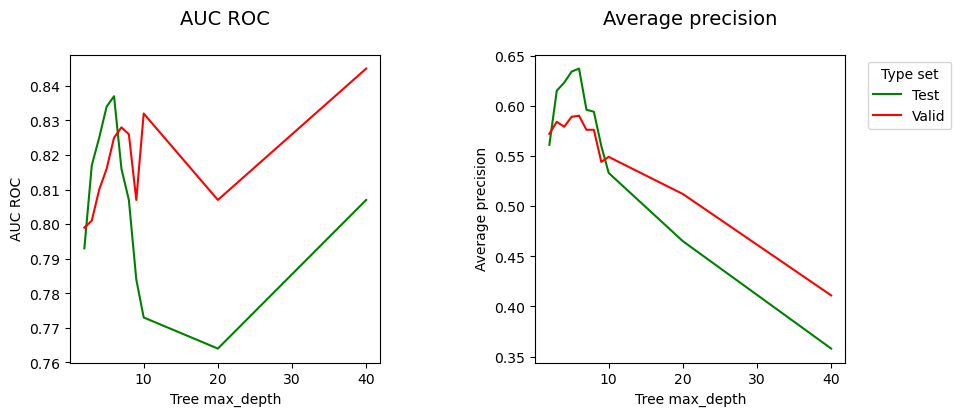

In [49]:
get_performances_plots(performances_validation, 
                       type_list=['Test','Valid'],
                       type_color_list=['#008000','#FF0000'])

These plots are interesting because they show the ability of the validation set to provide good estimates of the performance of the test set, and a way to select the best model.

Clearly, the test and valid functions differ in terms of exact values, but they follow the same trends, increasing and decreasing at similar points. We can't expect exact matches in terms of values since different sets are used for validating/testing.

These performances provide a good insight on what hyperparameters to select for the best model that would maximise the performance on an unseen test set, which is especially clear in the case of Average precision (a max depth between 3 and 6)

##### >> Repeated hold out validation

A better approach to hold out validation would be to repeat the same process several times on different, randomly selected train/validation tests and then average out the results to approximate the performance.

In [50]:
def repeated_hold_out_validation(transactions: pd.DataFrame, classifier, start_date_training, n_folds=4, sampling_ratio=0.7, type_set="Test", parameter_chosen=""):
    performances_folds = pd.DataFrame()

    # repeat get_performances() for n_folds
    for fold in range(n_folds):
        (train_set, test_set) = train_test_set(transactions, start_date_training, sampling_ratio=sampling_ratio, random_state=fold)

        # fit model
        model_and_predictions_dict = fit_model_and_get_preds(classifier, train_set, test_set)

        # calculate performances
        train_set.insert(0, "predictions_proba", model_and_predictions_dict['predictions_train'])
        performances_train = performance_evaluation(train_set, all=False)
        performances_train.columns = performances_train.columns.values + ' Train'
        
        test_set.insert(0, "predictions_proba", model_and_predictions_dict['predictions_test'])
        performances_test = performance_evaluation(test_set, all=False)
        performances_test.columns = performances_test.columns.values + ' ' + type_set

        perfs = pd.concat([performances_train, performances_test], axis=1)
        performances_folds = pd.concat([performances_folds, perfs], axis=0)
    
    performances_folds_mean = performances_folds.mean()
    performances_folds_std = performances_folds.std(ddof=0)

    performances_folds_mean = pd.DataFrame(performances_folds_mean).transpose()
    performances_folds_std = pd.DataFrame(performances_folds_std).transpose()
    performances_folds_std.columns = performances_folds_std.columns.values + ' Std'

    performances_summary = pd.concat([performances_folds_mean, performances_folds_std], axis=1)

    performances_summary['Parameter Chosen'] = parameter_chosen

    # this function returns a summary of the averaged out performances over all folds
    # as well as the performances obtained on each fold
    return performances_summary, performances_folds

Let's see the repeated holdout validation performances of a Decision Tree of depth 2.

In [51]:
classifier = DecisionTreeClassifier(max_depth=2, random_state=0)

perfs_repeated_hold_out_summary, perfs_repeated_hold_out_folds = repeated_hold_out_validation(transactions, 
                                                                                              classifier, 
                                                                                              start_date_training_validated, 
                                                                                              n_folds=4, sampling_ratio=0.7, 
                                                                                              type_set='Valid', parameter_chosen='2')

The repeated_holdout_validation function returns two DataFrames:

- perfs_repeated_holdout_summary: Summary of performance metrics over all folds, in terms of mean and standard variance for each performance metric.

- perfs_repeated_holdout_folds: Performance metrics obtained in each fold

In [52]:
perfs_repeated_hold_out_summary

,Average precision Train,AUC ROC Train,Average precision Valid,AUC ROC Valid,Average precision Train Std,AUC ROC Train Std,Average precision Valid Std,AUC ROC Valid Std,Parameter Chosen
0,0.5755,0.79475,0.56825,0.79975,0.009708,0.003961,0.005403,0.000829,2


In [53]:
perfs_repeated_hold_out_folds

,Average precision Train,AUC ROC Train,Average precision Valid,AUC ROC Valid
0,0.567,0.797,0.564,0.801
0,0.572,0.798,0.562,0.800
0,0.571,0.788,0.572,0.799
0,0.592,0.796,0.575,0.799


Let's compute the performances of varying depths of decision trees.
Let's set the Decision Tree's max_depth as numbers from 2 to 40.

In [54]:
params = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40]

perfs_repeated_holdout = pd.DataFrame()

for max_depth in params:
    print(f"Computing perfs for Decision Tree of depth {max_depth}...")

    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=0)

    perfs_repeated_holdout = pd.concat([perfs_repeated_holdout, 
                            repeated_hold_out_validation(transactions, classifier, 
                                                         start_date_training_validated,
                                                         n_folds=4,
                                                         sampling_ratio=0.7,
                                                         type_set='Valid', 
                                                         parameter_chosen=max_depth)[0]],
                            axis=0)
perfs_repeated_holdout.reset_index(inplace=True, drop=True)

Computing perfs for Decision Tree of depth 2...
Computing perfs for Decision Tree of depth 3...
Computing perfs for Decision Tree of depth 4...
Computing perfs for Decision Tree of depth 5...
Computing perfs for Decision Tree of depth 6...
Computing perfs for Decision Tree of depth 7...
Computing perfs for Decision Tree of depth 8...
Computing perfs for Decision Tree of depth 9...
Computing perfs for Decision Tree of depth 10...
Computing perfs for Decision Tree of depth 20...
Computing perfs for Decision Tree of depth 40...


In [55]:
perfs_repeated_holdout

,Average precision Train,AUC ROC Train,Average precision Valid,AUC ROC Valid,Average precision Train Std,AUC ROC Train Std,Average precision Valid Std,AUC ROC Valid Std,Parameter Chosen
0,0.57550,0.79475,0.56825,0.79975,0.009708,0.003961,0.005403,0.000829,2
1,0.60550,0.80650,0.58825,0.80650,0.003571,0.002958,0.003269,0.003775,3
2,0.62275,0.81375,0.58725,0.81200,0.006833,0.005449,0.019266,0.007280,4
3,0.63750,0.82250,0.58025,0.80875,0.007018,0.005500,0.019816,0.010034,5
4,0.64975,0.82800,0.56650,0.81250,0.004265,0.003464,0.009552,0.007297,6
5,0.66200,0.83900,0.56250,0.81750,0.002915,0.003162,0.016591,0.004975,7
6,0.68025,0.84550,0.56225,0.81600,0.005309,0.004031,0.018566,0.011467,8
7,0.69150,0.85600,0.54375,0.80775,0.005895,0.011769,0.018593,0.011648,9
8,0.70500,0.87400,0.54575,0.81850,0.011533,0.009192,0.021499,0.015977,10
9,0.85700,0.96900,0.51350,0.81200,0.013134,0.005745,0.026707,0.007649,20


Let's plot the validation and test accuracies in terms of AUC ROC, AP as a function of the decision tree depth.

In [56]:
performances

,Average precision Test,AUC ROC Test,Average precision Train,AUC ROC Train,Parameter Chosen
0,0.561,0.793,0.586,0.802,2
1,0.615,0.817,0.615,0.815,3
2,0.623,0.825,0.635,0.829,4
3,0.634,0.834,0.649,0.835,5
4,0.637,0.837,0.662,0.842,6
5,0.596,0.816,0.679,0.876,7
6,0.594,0.807,0.717,0.884,8
7,0.560,0.784,0.737,0.896,9
8,0.533,0.773,0.756,0.901,10
9,0.465,0.764,0.907,0.974,20


In [57]:
perfs_repeated_holdout['Average precision Test'] = performances['Average precision Test']
perfs_repeated_holdout['AUC ROC Test'] = performances['AUC ROC Test']

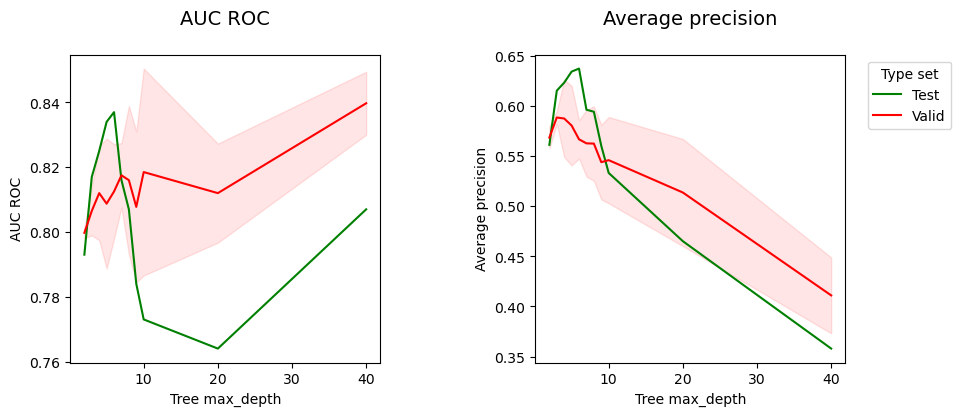

In [58]:
get_performances_plots(
    perfs_repeated_holdout, 
    performance_metrics_list=['AUC ROC', 'Average precision'], 
    type_list=['Test','Valid'],type_color_list=['#008000','#FF0000']
)

The repeated hold-out validation offers a better view of the expected performances, by providing confidence intervals.

The results are similar to the hold-out validation. The AP provides the most accurate approximation to the expected performance on the test set. The AUC ROC provides poorer estimates of the test performance.

##### >> Prequential validation

The repeated holdout validation relies on random subsets of the same training data to build prediction models. A limitation of this approach is that it reduces the expected performances of the models, as only subsets of data are used for training.

An alternative validation procedure consists in using training sets of similar sizes, taken from older historical data. The scheme is called prequential validation. Each fold shifts the training and validation sets by one block in the past.

Prequential validation has a very similar implementation to the repeated hold out validation. The only difference is that, for each fold, the starting dates for the training and validation sets are shifted by one block.

In [59]:
def prequential_validation(transactions: pd.DataFrame, classifier, 
                           start_date_training, 
                           n_folds=4,
                           type_set="Test", parameter_chosen=""):
    DELTA_ASSESSMENT = 7

    performances_folds=pd.DataFrame()
    
    for fold in range(n_folds):
        start_date_training_fold=start_date_training-datetime.timedelta(days=fold*DELTA_ASSESSMENT)
        
        # Get the training and test sets
        (train_set, test_set) = train_test_set(transactions, start_date_training=start_date_training_fold)
    
        # Fit model
        model_and_predictions_dict = fit_model_and_get_preds(classifier, train_set, test_set)
        
        # calculate performances
        train_set.insert(0, "predictions_proba", model_and_predictions_dict['predictions_train'])
        performances_train = performance_evaluation(train_set, all=False)
        performances_train.columns = performances_train.columns.values + ' Train'
        
        test_set.insert(0, "predictions_proba", model_and_predictions_dict['predictions_test'])
        performances_test = performance_evaluation(test_set, all=False)
        performances_test.columns = performances_test.columns.values + ' ' + type_set

        perfs = pd.concat([performances_train, performances_test], axis=1)
        performances_folds = pd.concat([performances_folds, perfs], axis=0)
    
    performances_folds_mean=performances_folds.mean()
    performances_folds_std=performances_folds.std(ddof=0)
    
    performances_folds_mean=pd.DataFrame(performances_folds_mean).transpose()
    performances_folds_std=pd.DataFrame(performances_folds_std).transpose()
    performances_folds_std.columns=performances_folds_std.columns.values+" Std"
    performances_summary = pd.concat([performances_folds_mean,performances_folds_std],axis=1)
    
    performances_summary['Parameter Chosen'] = parameter_chosen
    
    return performances_summary, performances_folds

Let's compute the validation performance with a Decision Tree of depth 2.

In [60]:
classifier = DecisionTreeClassifier(max_depth=2, random_state=0)

perfs_prequential_summary, perfs_prequential_folds = prequential_validation(transactions, classifier,
                                                                            start_date_training_validated,
                                                                            n_folds=4,
                                                                            type_set='Valid',
                                                                            parameter_chosen='2')

The prequential_validation function returns two DataFrames:

- perfs_prequential_summary: Summary of performance metrics over all folds, in terms of mean and standard variance for each performance metric.

- perfs_prequential_folds: Performance metrics obtained in each fold

In [61]:
perfs_prequential_summary

,Average precision Train,AUC ROC Train,Average precision Valid,AUC ROC Valid,Average precision Train Std,AUC ROC Train Std,Average precision Valid Std,AUC ROC Valid Std,Parameter Chosen
0,0.59375,0.80425,0.577,0.803,0.018322,0.013479,0.00755,0.004899,2


In [62]:
perfs_prequential_folds

,Average precision Train,AUC ROC Train,Average precision Valid,AUC ROC Valid
0,0.577,0.791,0.572,0.799
0,0.577,0.791,0.590,0.811
0,0.600,0.814,0.572,0.803
0,0.621,0.821,0.574,0.799


Let's compute the performances of varying depths of decision trees.
Let's set the Decision Tree's max_depth as numbers from 2 to 40.

In [63]:
params = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40]

perfs_prequential = pd.DataFrame()

for max_depth in params:
    print(f"Computing perfs for Decision Tree of depth {max_depth}...")

    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=0)

    perfs_prequential = pd.concat([perfs_prequential, 
                            prequential_validation(transactions, classifier, 
                                                         start_date_training_validated,
                                                         n_folds=4,
                                                         type_set='Valid', 
                                                         parameter_chosen=max_depth)[0]],
                            axis=0)
perfs_prequential.reset_index(inplace=True, drop=True)

Computing perfs for Decision Tree of depth 2...
Computing perfs for Decision Tree of depth 3...
Computing perfs for Decision Tree of depth 4...
Computing perfs for Decision Tree of depth 5...
Computing perfs for Decision Tree of depth 6...
Computing perfs for Decision Tree of depth 7...
Computing perfs for Decision Tree of depth 8...
Computing perfs for Decision Tree of depth 9...
Computing perfs for Decision Tree of depth 10...
Computing perfs for Decision Tree of depth 20...
Computing perfs for Decision Tree of depth 40...


In [64]:
perfs_prequential

,Average precision Train,AUC ROC Train,Average precision Valid,AUC ROC Valid,Average precision Train Std,AUC ROC Train Std,Average precision Valid Std,AUC ROC Valid Std,Parameter Chosen
0,0.59375,0.80425,0.57700,0.80300,0.018322,0.013479,0.007550,0.004899,2
1,0.62375,0.81800,0.59775,0.81325,0.016192,0.011358,0.011648,0.008871,3
2,0.64475,0.82600,0.58450,0.81300,0.018458,0.010124,0.023092,0.010050,4
3,0.65750,0.83125,0.58300,0.81625,0.016530,0.007790,0.024990,0.011009,5
4,0.66950,0.83900,0.57300,0.81075,0.012600,0.002739,0.026991,0.025994,6
5,0.68225,0.84625,0.55750,0.80700,0.008555,0.005494,0.031894,0.020616,7
6,0.69500,0.85950,0.54650,0.80500,0.009487,0.007953,0.027482,0.024930,8
7,0.71725,0.86475,0.54375,0.79700,0.015303,0.011300,0.031483,0.026730,9
8,0.72775,0.88750,0.53500,0.80175,0.018061,0.011715,0.031472,0.037063,10
9,0.86225,0.96425,0.49325,0.79550,0.014856,0.007395,0.020765,0.022600,20


Let's plot the validation and test accuracies in terms of AUC ROC, AP as a function of the decision tree depth.

In [65]:
perfs_prequential['Average precision Test'] = performances['Average precision Test']
perfs_prequential['AUC ROC Test'] = performances['AUC ROC Test']

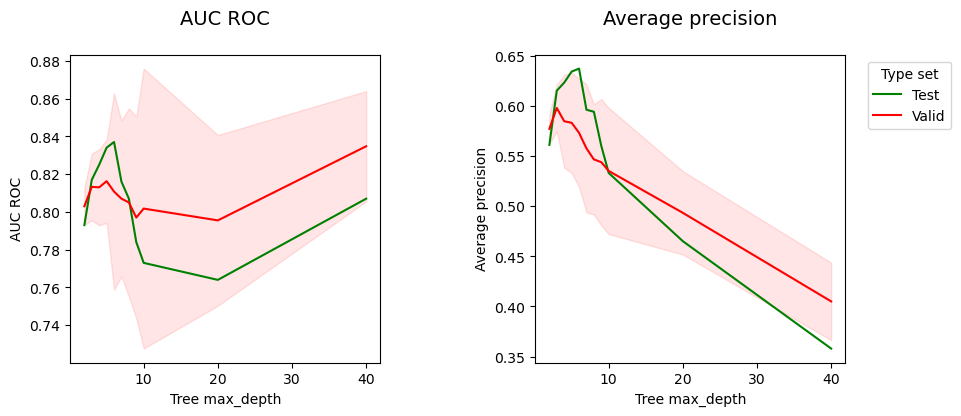

In [66]:
get_performances_plots(perfs_prequential, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Valid'], type_color_list=['#008000','#FF0000'])

We can also get the performances on the next `n_folds` weeks using the same code, but setting the starting day for training in such a way that estimates for the test period are obtained. This allows to provide confidence intervals for the performances on the test data.

In [67]:
params = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40]

perfs_prequential_test = pd.DataFrame()

n_folds = 4

for max_depth in params:
    print(f"Computing perfs for Decision Tree of depth {max_depth}...")

    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=0)

    start_date = start_date_training + datetime.timedelta(days=7*(n_folds-1)) 

    perfs_prequential_test = pd.concat([perfs_prequential_test, 
                            prequential_validation(transactions, classifier, 
                                                         start_date,
                                                         n_folds=n_folds,
                                                         type_set='Test', 
                                                         parameter_chosen=max_depth)[0]],
                            axis=0)
perfs_prequential_test.reset_index(inplace=True, drop=True)

Computing perfs for Decision Tree of depth 2...
Computing perfs for Decision Tree of depth 3...
Computing perfs for Decision Tree of depth 4...
Computing perfs for Decision Tree of depth 5...
Computing perfs for Decision Tree of depth 6...
Computing perfs for Decision Tree of depth 7...
Computing perfs for Decision Tree of depth 8...
Computing perfs for Decision Tree of depth 9...
Computing perfs for Decision Tree of depth 10...
Computing perfs for Decision Tree of depth 20...
Computing perfs for Decision Tree of depth 40...


In [68]:
perfs_prequential_test

,Average precision Train,AUC ROC Train,Average precision Test,AUC ROC Test,Average precision Train Std,AUC ROC Train Std,Average precision Test Std,AUC ROC Test Std,Parameter Chosen
0,0.59200,0.80800,0.57750,0.80750,0.018000,0.011640,0.012757,0.008958,2
1,0.62325,0.82000,0.60675,0.81950,0.015270,0.007906,0.006418,0.005025,3
2,0.64500,0.83000,0.62825,0.82625,0.015668,0.006819,0.005540,0.007293,4
3,0.65875,0.83600,0.62600,0.81875,0.014906,0.008276,0.013210,0.017768,5
4,0.67125,0.84725,0.61200,0.81725,0.016784,0.008043,0.015780,0.019626,6
5,0.69275,0.85950,0.58925,0.79750,0.012377,0.013295,0.011256,0.021651,7
6,0.70900,0.86550,0.57325,0.78950,0.009798,0.014925,0.014481,0.021789,8
7,0.72100,0.87775,0.56125,0.78300,0.014883,0.012296,0.012153,0.025475,9
8,0.73800,0.88175,0.54100,0.77200,0.012629,0.012597,0.010559,0.027884,10
9,0.87875,0.96925,0.49025,0.77400,0.026423,0.010986,0.033804,0.010607,20


In [69]:
perfs_prequential['AUC ROC Test']=perfs_prequential_test['AUC ROC Test']
perfs_prequential['Average precision Test']=perfs_prequential_test['Average precision Test']
perfs_prequential['AUC ROC Test Std']=perfs_prequential_test['AUC ROC Test Std']
perfs_prequential['Average precision Test Std']=perfs_prequential_test['Average precision Test Std']

In [70]:
perfs_prequential

,Average precision Train,AUC ROC Train,Average precision Valid,AUC ROC Valid,Average precision Train Std,AUC ROC Train Std,Average precision Valid Std,AUC ROC Valid Std,Parameter Chosen,Average precision Test,AUC ROC Test,AUC ROC Test Std,Average precision Test Std
0,0.59375,0.80425,0.57700,0.80300,0.018322,0.013479,0.007550,0.004899,2,0.57750,0.80750,0.008958,0.012757
1,0.62375,0.81800,0.59775,0.81325,0.016192,0.011358,0.011648,0.008871,3,0.60675,0.81950,0.005025,0.006418
2,0.64475,0.82600,0.58450,0.81300,0.018458,0.010124,0.023092,0.010050,4,0.62825,0.82625,0.007293,0.005540
3,0.65750,0.83125,0.58300,0.81625,0.016530,0.007790,0.024990,0.011009,5,0.62600,0.81875,0.017768,0.013210
4,0.66950,0.83900,0.57300,0.81075,0.012600,0.002739,0.026991,0.025994,6,0.61200,0.81725,0.019626,0.015780
5,0.68225,0.84625,0.55750,0.80700,0.008555,0.005494,0.031894,0.020616,7,0.58925,0.79750,0.021651,0.011256
6,0.69500,0.85950,0.54650,0.80500,0.009487,0.007953,0.027482,0.024930,8,0.57325,0.78950,0.021789,0.014481
7,0.71725,0.86475,0.54375,0.79700,0.015303,0.011300,0.031483,0.026730,9,0.56125,0.78300,0.025475,0.012153
8,0.72775,0.88750,0.53500,0.80175,0.018061,0.011715,0.031472,0.037063,10,0.54100,0.77200,0.027884,0.010559
9,0.86225,0.96425,0.49325,0.79550,0.014856,0.007395,0.020765,0.022600,20,0.49025,0.77400,0.010607,0.033804


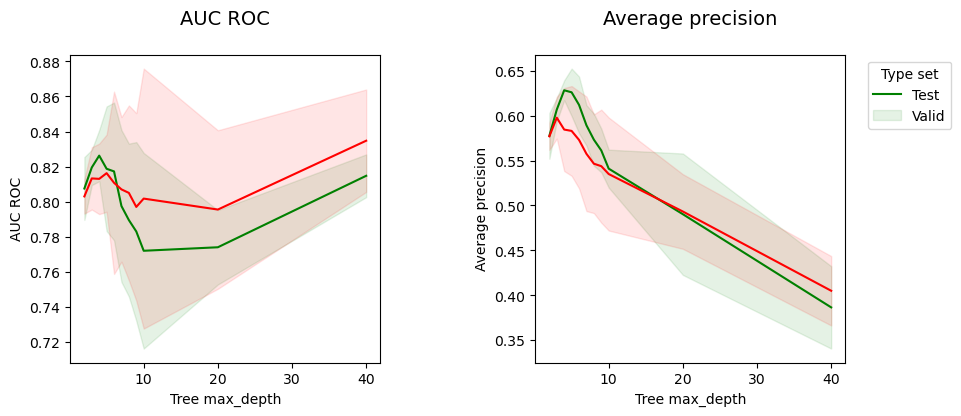

In [71]:
get_performances_plots(perfs_prequential, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Valid'], type_color_list=['#008000','#FF0000'])

These plots show a better agreement between the validation and test performances. The AUC ROC is still problematic, as it would choose a depth of 40 as the best performance for the validation set, whereas optimal depths are in the range 3 to 6. 

The AP follows similar trends for the validation and test set.

##### Integrating prequential validation with sklearn

Sklearn provides 8 strategies for splitting data for validation: `GroupKFold`, `GroupShuffleSplit`, `KFold`, `ShuffleSplit`, `StratifiedGroupKFold`, `StratifiedKFold`, `StratifiedShuffleSplit`, `TimeSeriesSplit`.

None of these support the prequential split defined before so let's integrate it now.

Define a `prequential_split` function that returns the indices of the training and test sets for each of the folds of a prequential split.

In [72]:
def prequential_split(transactions, start_date_training, n_folds=4):
    
    prequential_split_indices=[]
        
    for fold in range(n_folds):
        # Shift back start date for training by the fold index times the assessment period (7 days)
        start_date_training_fold = start_date_training - datetime.timedelta(days=fold * 7)
        
        # Get the training and test (assessment) sets
        (train_set, test_set) = train_test_set(transactions, start_date_training=start_date_training_fold)
    
        # Get the indices from the two sets, and add them to the list of prequential splits
        indices_train = list(train_set.index)
        indices_test = list(test_set.index)
        
        prequential_split_indices.append((indices_train,indices_test))
    
    return prequential_split_indices

Sklearn allows to automate the fitting and assessment of models with different hyperparameters using the `GridSearchCV` function.

Its main parameters are
- estimator: the estimator to use, which will be a decision tree
- param_grid: the set of hyperparameters for the estimator.
- scoring: the scoring functions to use. I will use the AUC ROC and Average Precision
- n_jobs: the number of cores to use. setting to -1 means use all available cores
- refit: whether the model should be fitted with all data after the cross validation. this will be set to false, since we only need the results of the cross validation.
- cv: the cross-validation splitting strategy. the prequential validation will be used, by passing the indices returned by the prequentialSplit function.

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

classifier = DecisionTreeClassifier()

# hyperparams to test
params = {'clf__max_depth': [2, 4],
          'clf__random_state': [0]}

# scoring functions
scoring = {'roc_auc': 'roc_auc',
           'average_precision': 'average_precision'}

# create pipeline to scale data before fitting the model
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', classifier)])
                  
# indices for the prequential validation
prequential_split_indices = prequential_split(transactions, start_date_training_validated, n_folds=4)

# GridSearch
grid_search = GridSearchCV(pipeline, param_grid=params, scoring=scoring,
                           cv=prequential_split_indices, refit=False,
                           n_jobs=-1)

X = transactions[features]
y = transactions['TX_FRAUD']

In [74]:
grid_search.fit(X, y)

print('Finished fitting GridSearchCV')

Finished fitting GridSearchCV


In [75]:
grid_search.cv_results_

{'mean_fit_time': array([0.31605011, 0.28674269]),
 'std_fit_time': array([0.00594898, 0.00379625]),
 'mean_score_time': array([0.01887345, 0.01306581]),
 'std_score_time': array([0.00157717, 0.00031964]),
 'param_clf__max_depth': masked_array(data=[2, 4],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_clf__random_state': masked_array(data=[0, 0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__max_depth': 2, 'clf__random_state': 0},
  {'clf__max_depth': 4, 'clf__random_state': 0}],
 'split0_test_roc_auc': array([0.79881144, 0.81007303]),
 'split1_test_roc_auc': array([0.81105524, 0.82794437]),
 'split2_test_roc_auc': array([0.80343654, 0.7995351 ]),
 'split3_test_roc_auc': array([0.79858917, 0.81374945]),
 'mean_test_roc_auc': array([0.8029731 , 0.81282549]),
 'std_test_roc_auc': array([0.00505158, 0.01016913]),
 'rank_test_roc_auc': array([2, 1], dtype=int32),
 'split0_test_avera

Prettify these results.

In [76]:
performances = pd.DataFrame()

type="Valid"

performance_metrics_list_grid = ['roc_auc', 'average_precision']
performance_metrics_list = ['AUC ROC', 'Average precision']


for i in range(len(performance_metrics_list_grid)):
    performances[performance_metrics_list[i] + ' ' + type] = grid_search.cv_results_['mean_test_' + performance_metrics_list_grid[i]]
    performances[performance_metrics_list[i] + ' ' + type + ' Std'] = grid_search.cv_results_['std_test_' + performance_metrics_list_grid[i]]

performances['Execution time'] = grid_search.cv_results_['mean_fit_time']

performances['Parameters'] = list(grid_search.cv_results_['params'])

In [77]:
performances

,AUC ROC Valid,AUC ROC Valid Std,Average precision Valid,Average precision Valid Std,Execution time,Parameters
0,0.802973,0.005052,0.576790,0.007578,0.316050,"{'clf__max_depth': 2, 'clf__random_state': 0}"
1,0.812825,0.010169,0.582939,0.025511,0.286743,"{'clf__max_depth': 4, 'clf__random_state': 0}"


It's possible to obtain the same results as in the [prequential section](#prequential-validation) using GridSearchCV

Define a function `prequential_grid_search` that implements the grid search above.

In [78]:
def prequential_grid_search(transactions, 
                            classifier, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            type='Test',
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):

    # create pipeline to scale data before fitting the model
    pipeline = Pipeline([('scaler', StandardScaler()),
                        ('clf', classifier)])
                      
    # indices for the prequential validation
    prequential_split_indices = prequential_split(transactions, start_date_training, n_folds=n_folds)

    # GridSearch
    grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring=scoring,
                              cv=prequential_split_indices, refit=False,
                              n_jobs=n_jobs)

    X = transactions[features]
    y = transactions['TX_FRAUD']

    grid_search.fit(X, y)

    performances = pd.DataFrame()

    for i in range(len(performance_metrics_list_grid)):
        performances[performance_metrics_list[i] + ' ' + type] = grid_search.cv_results_['mean_test_' + performance_metrics_list_grid[i]]
        performances[performance_metrics_list[i] + ' ' + type + ' Std'] = grid_search.cv_results_['std_test_' + performance_metrics_list_grid[i]]

    performances['Parameters'] = grid_search.cv_results_['params']
    performances['Execution time'] = grid_search.cv_results_['mean_fit_time']

    return performances

We can estimate the validation performances of a decision tree model with varying depth by setting `start_date_training` to `start_date_training_validated`.

In [79]:
classifier = DecisionTreeClassifier()

parameters = {'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40],
              'clf__random_state': [0]}

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision'}

performances_validation = prequential_grid_search(transactions, classifier,
                                                  parameters, scoring,
                                                  start_date_training_validated,
                                                  n_folds=4,
                                                  type='Valid',
                                                  performance_metrics_list_grid=performance_metrics_list_grid,
                                                  performance_metrics_list=performance_metrics_list)

And the test performances by setting start_date_training accordingly.

In [80]:
performances_test = prequential_grid_search(transactions, classifier,
                                                  parameters, scoring,
                                                  start_date_training=start_date_training+datetime.timedelta(days=(n_folds - 1) * 7),
                                                  n_folds=4,
                                                  type='Test',
                                                  performance_metrics_list_grid=performance_metrics_list_grid,
                                                  performance_metrics_list=performance_metrics_list)

Combining both performances into a single dataframe.

In [81]:
performances_validation.drop(columns=['Parameters', 'Execution time'], inplace=True)

performances = pd.concat([performances_validation, performances_test], axis=1)

In [82]:
# Use the max_depth as the label for plotting
parameters_dict = dict(performances['Parameters'])
max_depth = [parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]
performances['Parameter Chosen'] = max_depth

In [83]:
performances

,AUC ROC Valid,AUC ROC Valid Std,Average precision Valid,Average precision Valid Std,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Parameters,Execution time,Parameter Chosen
0,0.802973,0.005052,0.576790,0.007578,0.807308,0.009009,0.577392,0.012610,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.380100,2
1,0.813307,0.008867,0.597963,0.011622,0.819346,0.004863,0.606938,0.006300,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.295559,3
2,0.812825,0.010169,0.582939,0.025511,0.826091,0.007537,0.628241,0.005549,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.284683,4
3,0.816046,0.011016,0.581664,0.027552,0.818974,0.017592,0.625921,0.013116,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.323322,5
4,0.812322,0.024513,0.573366,0.026206,0.817470,0.019638,0.612012,0.015780,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.362728,6
5,0.808869,0.018639,0.557962,0.031009,0.797463,0.021679,0.588796,0.012107,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.450196,7
6,0.806533,0.022734,0.547124,0.026660,0.789332,0.021939,0.573561,0.013823,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.491371,8
7,0.798805,0.024928,0.545069,0.030387,0.782683,0.025557,0.560635,0.012388,"{'clf__max_depth': 9, 'clf__random_state': 0}",0.478655,9
8,0.803171,0.035653,0.534574,0.030649,0.772018,0.027971,0.541147,0.010690,"{'clf__max_depth': 10, 'clf__random_state': 0}",0.505272,10
9,0.796115,0.021821,0.492108,0.019587,0.774000,0.010862,0.491294,0.034076,"{'clf__max_depth': 20, 'clf__random_state': 0}",0.841590,20


Plot this

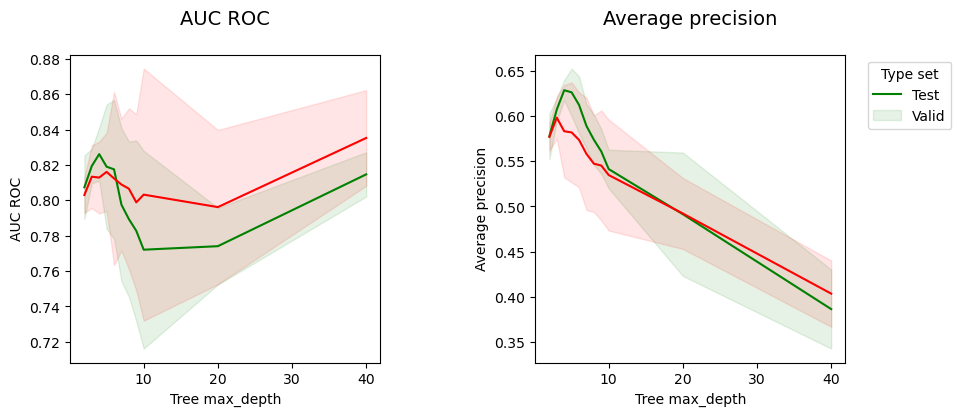

In [84]:
get_performances_plots(performances, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Valid'], type_color_list=['#008000','#FF0000'])

Same results as previous section

### 5. Model Selection

Let's reproduce the prequential validation pipeline proposed before using fresh data.

I will load 3 months of transaction data, from June 11th to September 14th 2018.

In [85]:
start_date = datetime.datetime.strptime('2018-06-11', "%Y-%m-%d")
end_date = datetime.datetime.strptime('2018-09-14', "%Y-%m-%d")

transactions[(start_date <= transactions.TX_DATETIME) & (transactions.TX_DATETIME <= end_date)]

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_NIGHT,TX_WEEKEND,CUSTOMER_N_TX_LAST_1_DAYS,...,CUSTOMER_N_TX_LAST_7_DAYS,CUSTOMER_AVG_SPENDING_LAST_7_DAYS,CUSTOMER_N_TX_LAST_30_DAYS,CUSTOMER_AVG_SPENDING_LAST_30_DAYS,TERMINAL_N_TX_LAST_1_DAYS,TERMINAL_RISK_SCORE_LAST_1_DAYS,TERMINAL_N_TX_LAST_7_DAYS,TERMINAL_RISK_SCORE_LAST_7_DAYS,TERMINAL_N_TX_LAST_30_DAYS,TERMINAL_RISK_SCORE_LAST_30_DAYS
680886,2018-06-11 00:00:24,3711,8121,75.81,6134424,71,0,1,0,10.0,...,34.0,69.421471,124.0,70.598710,2.0,0.0,10.0,0.0,38.0,0.000000
680887,2018-06-11 00:00:25,1320,867,101.89,6134425,71,0,1,0,3.0,...,27.0,92.666667,117.0,83.699402,1.0,0.0,10.0,0.0,31.0,0.032258
680888,2018-06-11 00:01:46,824,7954,44.72,6134506,71,0,1,0,2.0,...,23.0,37.035217,80.0,40.290125,2.0,0.0,14.0,0.0,35.0,0.000000
680889,2018-06-11 00:02:40,1085,8595,23.08,6134560,71,0,1,0,3.0,...,24.0,55.140833,101.0,54.151386,1.0,0.0,8.0,0.0,27.0,0.000000
680890,2018-06-11 00:02:55,346,4909,98.13,6134575,71,0,1,0,1.0,...,7.0,57.628571,38.0,63.603158,4.0,0.0,13.0,0.0,30.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591168,2018-09-13 23:58:06,2630,368,79.08,14342286,165,0,0,0,4.0,...,22.0,62.207727,91.0,65.199780,2.0,0.0,6.0,0.0,20.0,0.000000
1591169,2018-09-13 23:58:27,3232,472,5.08,14342307,165,0,0,0,7.0,...,26.0,4.808077,92.0,5.025870,0.0,0.0,5.0,0.0,16.0,0.000000
1591170,2018-09-13 23:58:31,4793,243,60.69,14342311,165,0,0,0,3.0,...,29.0,40.378621,119.0,43.817899,0.0,0.0,7.0,0.0,19.0,0.000000
1591171,2018-09-13 23:59:45,421,1357,12.38,14342385,165,0,0,0,2.0,...,16.0,26.176875,102.0,25.417059,2.0,0.0,14.0,0.0,50.0,0.000000


The start date for training will be set to 2018-07-25, and the deltas to 7 days as before.

In [86]:
# number of folds for prequential validation
n_folds = 4

start_date_training = datetime.datetime.strptime('2018-07-25', '%Y-%m-%d')
delta_train = delta_test = delta_valid = delta_delay = delta_assessment = 7

# start date of validation will be 2 weeks before training
start_date_training_for_valid = start_date_training + datetime.timedelta(days=-(delta_valid + delta_delay))
# start date of test will be 3 weeks after training
start_date_training_for_test = start_date_training + datetime.timedelta(days=(n_folds - 1) * delta_test)

print('start_date_training_for_valid: ', start_date_training_for_valid)
print('start_date_training_for_test: ', start_date_training_for_test)

start_date_training_for_valid:  2018-07-11 00:00:00
start_date_training_for_test:  2018-08-15 00:00:00


Performance metrics will be AUC ROC and Average Precision (AP)

In [87]:
performance_metrics_list_grid = ['roc_auc', 'average_precision']
performance_metrics_list = ['AUC ROC', 'Average precision']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision'}

Let's also define a `model_selection_wrapper` function, that will perform prequential validation for both the validation and the test sets.

In [88]:
def model_selection_wrapper(transactions, 
                            classifier, 
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            performance_metrics_list_grid=['roc_auc, average_precision'],
                            performance_metrics_list=['AUC ROC, Average precision'],
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_validation=prequential_grid_search(transactions, classifier, 
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            type='Validation',
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_test=prequential_grid_search(transactions, classifier, 
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            type='Test',
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Combine the two resulting DataFrames
    performances_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances = pd.concat([performances_test,performances_validation], axis=1)

    return performances

Prequential validation can now be performed by:
- defining which classifier to use
- defining which parameters to test
- fitting the models and assessing the performances

#### 5.1 Decision Tree

The main hyperparameter of Decison Trees is the max_depth, that defaults to None (nodes are expanded until all leaves are pure)

For example, using Decision Trees as prediction models, the implementation for varying depths of [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40] is:

In [89]:
classifier = DecisionTreeClassifier()

parameters = {'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40],
              'clf__random_state': [0]}

performances_decision_tree = model_selection_wrapper(transactions, classifier,
                                       parameters, scoring,
                                       start_date_training_for_valid, start_date_training_for_test,
                                       n_folds, performance_metrics_list_grid,
                                       performance_metrics_list,
                                       n_jobs=-1)

params_dict = dict(performances_decision_tree['Parameters'])
performances_decision_tree['Parameter Chosen'] = [params_dict[i]['clf__max_depth'] for i in range(len(params_dict))]

In [90]:
performances_decision_tree

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameter Chosen
0,0.807308,0.009009,0.577392,0.012610,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.301820,0.802973,0.005052,0.576790,0.007578,2
1,0.819346,0.004863,0.606938,0.006300,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.250925,0.813307,0.008867,0.597963,0.011622,3
2,0.826091,0.007537,0.628241,0.005549,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.293243,0.812825,0.010169,0.582939,0.025511,4
3,0.818974,0.017592,0.625921,0.013116,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.346403,0.816046,0.011016,0.581664,0.027552,5
4,0.817470,0.019638,0.612012,0.015780,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.365159,0.812322,0.024513,0.573366,0.026206,6
5,0.797463,0.021679,0.588796,0.012107,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.395119,0.808869,0.018639,0.557962,0.031009,7
6,0.789332,0.021939,0.573561,0.013823,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.481699,0.806533,0.022734,0.547124,0.026660,8
7,0.782683,0.025557,0.560635,0.012388,"{'clf__max_depth': 9, 'clf__random_state': 0}",0.521895,0.798805,0.024928,0.545069,0.030387,9
8,0.772018,0.027971,0.541147,0.010690,"{'clf__max_depth': 10, 'clf__random_state': 0}",0.529640,0.803171,0.035653,0.534574,0.030649,10
9,0.774000,0.010862,0.491294,0.034076,"{'clf__max_depth': 20, 'clf__random_state': 0}",0.844910,0.796115,0.021821,0.492108,0.019587,20


This DF provides performances on both validation and test sets, using a Deicison Tree of varying max_depth. Each row corresponds to a different max_depth.

The goal is to extract from this table the most relevant information, that which answers the following questions:
1. Which parameter provides the best performances on the validation set?
2. What is the performances on the test set using this parameter?
3. What parameter would have provided the best performance on the test set?

Define a `get_summary_performances` function to answer these questions.

In [91]:
def get_summary_performances(performances: pd.DataFrame):
    PARAM_COLUMN = 'Parameter Chosen'

    metrics = ['AUC ROC', 'Average precision']
    summary = pd.DataFrame(columns=metrics)

    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances.reset_index(drop=True, inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    test_performance = []

    # For each metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
        # Find the index which provides the best validation performance
        max_valid = np.argmax(performances[metric + ' Validation'].values)
        index_best_validation_performance = performances.index[max_valid]
    
        # Append the corresponding parameters
        best_estimated_parameters.append(performances[PARAM_COLUMN].iloc[index_best_validation_performance])
        
        # Add validation (expected) performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances[metric+' Validation'].iloc[index_best_validation_performance],3))+
                ' +/- '+
                str(round(performances[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
        # Add test (actual) performance to the test_performance list (mean+/-std)
        test_performance.append(
                str(round(performances[metric+' Test'].iloc[index_best_validation_performance],3))+
                ' +/- '+
                str(round(performances[metric+' Test Std'].iloc[index_best_validation_performance],2))
        )
    
    # Add results to the performances_results DataFrame
    summary.loc["Best estimated parameters"] = best_estimated_parameters
    summary.loc["Validation performance"] = validation_performance
    summary.loc["Test performance"] = test_performance

    # --------------------------------------------------------------------------------------

    # Lists of parameters/performances that will be retrieved for the optimal parameters
    optimal_test_performance = []
    optimal_parameters = []

    # For each performance metric, get the performance for the optimal parameter
    for metric in metrics:
        # Find the index which provides the optimal performance
        max_test = np.argmax(performances[metric + ' Test'].values)
        index_optimal_test_performance = performances.index[max_test]
    
        # Retrieve the corresponding parameters
        optimal_parameters.append(performances[PARAM_COLUMN].iloc[index_optimal_test_performance])
    
        # Add test performance to the test_performance list (mean+/-std)
        optimal_test_performance.append(
                str(round(performances[metric + ' Test'].iloc[index_optimal_test_performance],3))+
                ' +/- '+
                str(round(performances[metric+' Test Std'].iloc[index_optimal_test_performance],2))
        )

    # Add results to the performances_results DataFrame
    summary.loc["Optimal parameters"]=optimal_parameters
    summary.loc["Optimal test performance"]=optimal_test_performance

    return summary

In [92]:
summary_decision_tree = get_summary_performances(performances_decision_tree)
summary_decision_tree

,AUC ROC,Average precision
Best estimated parameters,40,3
Validation performance,0.835 +/- 0.01,0.598 +/- 0.01
Test performance,0.815 +/- 0.01,0.607 +/- 0.01
Optimal parameters,4,4
Optimal test performance,0.826 +/- 0.01,0.628 +/- 0.01


Row 1 provides the parameter that maximises performance on the validation set.

Rows 2 and 3 provide the performances obtained on validation and test sets using the parameter on Row 1 (best estimated parameter)

Row 4 provides the parameter that maximises performance on the test set (optimal parameter).
The last row shows the performance obtained on the test set using the optimal parameter.

Observations:
1. The optimal parameter depends on the performance metrics: It is a max_depth of 4 for AUC ROC and AP.
2. The best parameters for the validation may not be the optimal parameter for the test set. This is the case for the AUC ROC (max_depth of 40 for the validation set vs. 4 for the test set), and the AP (maximum depth of 3 for the validation set vs. 4 for the test set).

Let's plot the performances as a function of the decision tree depth.

The vertical dashed line is the optimal parameter.

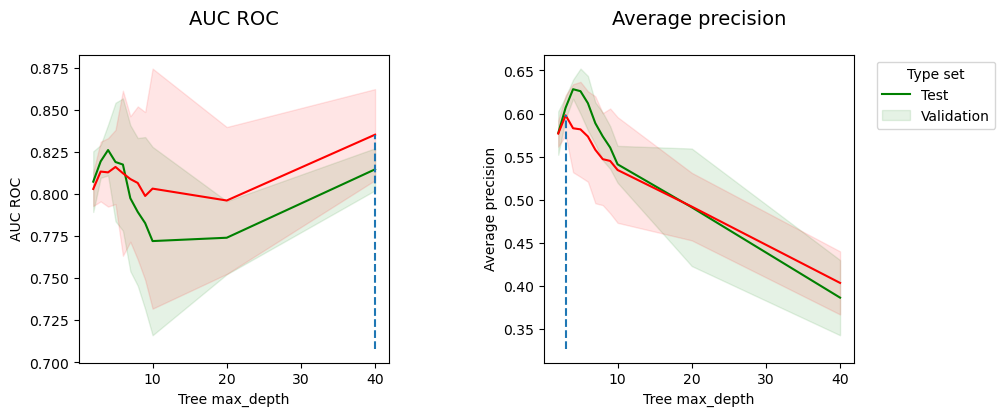

In [93]:
get_performances_plots(performances_decision_tree, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Validation'], type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_decision_tree)

#### 5.2 Logistic Regression

The main hyperparameter of Decision Trees was max_depth.

For logistic regression, it is the regularization parameter `C`, that has a default value of 1.

Regularization helps avoid overfitting by adding a penalty term to the cost function of the model. The penalty term reduces the complexity of the model by shrinking or eliminating some of the coefficients of the input variables.

Let's fit models with varying values for the regularization parameter, for example in the set [0.1,1,10,100]:

In [94]:
classifier = LogisticRegression()

parameters = {'clf__C': [0.1, 1, 10, 100],
              'clf__random_state': [0]}


performances_logistic_regression = model_selection_wrapper(transactions, classifier,
                                       parameters, scoring,
                                       start_date_training_for_valid, start_date_training_for_test,
                                       n_folds, performance_metrics_list_grid,
                                       performance_metrics_list,
                                       n_jobs=-1)

params_dict = dict(performances_logistic_regression['Parameters'])
performances_logistic_regression['Parameter Chosen'] = [params_dict[i]['clf__C'] for i in range(len(params_dict))]

In [95]:
summary_logistic_regression = get_summary_performances(performances_logistic_regression)
summary_logistic_regression

,AUC ROC,Average precision
Best estimated parameters,100.0,100.0
Validation performance,0.889 +/- 0.01,0.659 +/- 0.01
Test performance,0.891 +/- 0.01,0.669 +/- 0.01
Optimal parameters,100.0,100.0
Optimal test performance,0.891 +/- 0.01,0.669 +/- 0.01


Let's plot the performances as a function of the C value, together with the value that provides the best estimated performances.

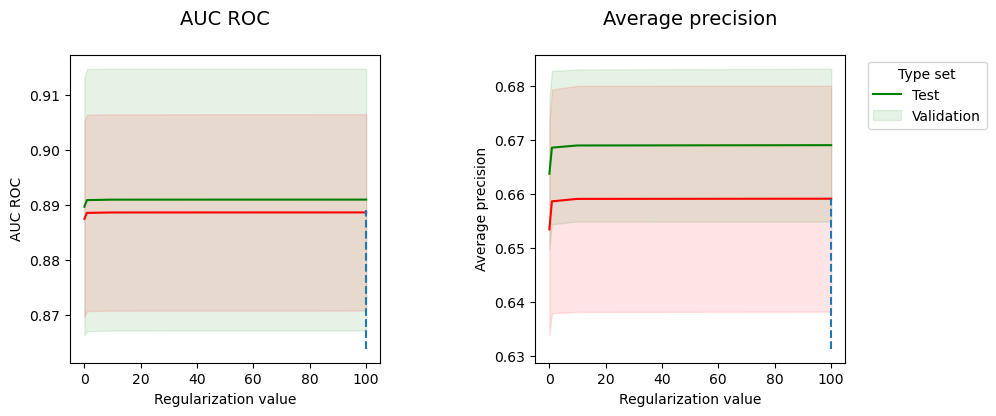

In [96]:
get_performances_plots(performances_logistic_regression, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Validation'], type_color_list=['#008000','#FF0000'],
                       parameter_name="Regularization value",
                       summary_performances=summary_logistic_regression)

Performances are a bit lower for a low C value (0.1). But then seem to remain constant from 1 and above.

Therefore, the default value of 1 is a sensible choice.

#### 5.3 Random Forest

The two main hyperparams of random forest are:
- max_depth - the maximum depth of all trees
- n_estimators - the number of trees, default value: 100

The default value for max_depth is None (nodes are expanded until all leaves are pure)

Let's try different values for max_depth: [5, 10, 20, 50], and n_estimators: [25, 50, 100]

In [97]:
import time

classifier = RandomForestClassifier()

parameters = {'clf__max_depth': [5, 10, 20, 50],
              'clf__n_estimators': [25, 50, 100],
              'clf__random_state': [0]}

start_time = time.time()

performances_random_forest = model_selection_wrapper(transactions, classifier,
                                                     parameters, scoring,
                                                     start_date_training_for_valid, start_date_training_for_test,
                                                     n_folds, performance_metrics_list_grid,
                                                     performance_metrics_list, n_jobs=-1)

exec_time = time.time() - start_time

params_dict = dict(performances_random_forest['Parameters'])
performances_random_forest['Parameter Chosen']=[str(params_dict[i]['clf__n_estimators']) +
                                                '/' +
                                                str(params_dict[i]['clf__max_depth']) for i in range(len(params_dict))]


print('Executed in ', exec_time, ' seconds')

Executed in  112.0113275051117  seconds


In [98]:
summary_random_forest = get_summary_performances(performances_random_forest)
summary_random_forest

,AUC ROC,Average precision
Best estimated parameters,100/20,100/20
Validation performance,0.9 +/- 0.0,0.729 +/- 0.01
Test performance,0.893 +/- 0.01,0.717 +/- 0.0
Optimal parameters,100/10,100/20
Optimal test performance,0.895 +/- 0.01,0.717 +/- 0.0


So the best performance is obtained with forests of 100 trees of depths 10 or 20

In order to visualise, the number of trees needs to be fixed first and vary the max_depth, and vice versa.

Fix n_estimators to 100:

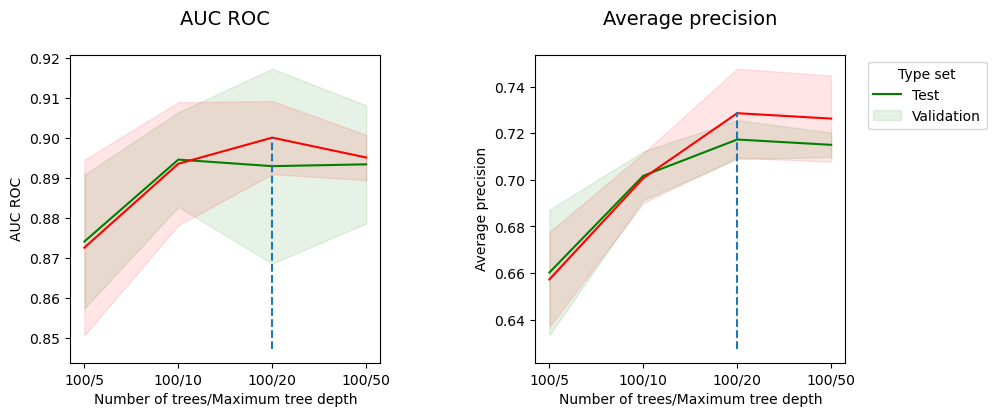

In [99]:
performances_rf_fixed_number_of_trees = performances_random_forest[performances_random_forest["Parameter Chosen"].str.startswith("100")]

summary_fixed_number_of_trees = get_summary_performances(performances_rf_fixed_number_of_trees)

get_performances_plots(performances_rf_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Validation'], type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_fixed_number_of_trees)

The worst performance is obtained at a max_depth of 5.
Performance increases until a max_depth of 20, where it stabilises then decreases a bit.

Therefore, let's fix the max_depth to 20 and vary the number of trees.

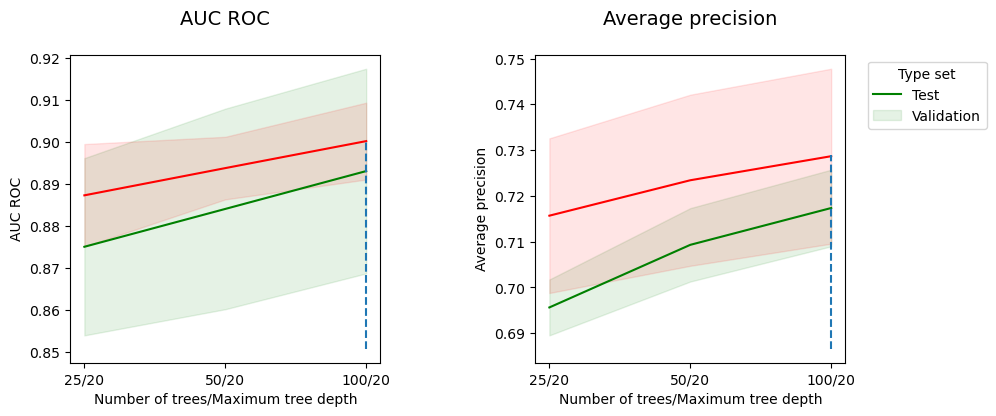

In [100]:
performances_rf_fixed_max_depth = performances_random_forest[performances_random_forest["Parameter Chosen"].str.endswith("20")]

summary_fixed_max_depth = get_summary_performances(performances_rf_fixed_max_depth)

get_performances_plots(performances_rf_fixed_max_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Validation'], type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_fixed_max_depth)

For both metrics, the trend is an increase in performance as the number of trees is increased.

#### 5.4 XGBoost

XGBoost is a powerful algorithm whose tuning relies on many hyperparameters. While Random Forest trains 100 trees in parallel and then averages all the results into one, XGBoost works by training trees in sequence, where each tree improves on the shortcomings of the previous one.

The most important hyperpamaters are:
- max_depth - the max tree depth of all trees, default: 6
- n_estimators - the number of trees, default: 100
- learning_rate - controls the step size at which the algorithm makes updates to the model weights, default: 0.3

Let's try other combinations:
- max_depth in [3,6,9]
- n_estimators in [25,10,100]
- learning_rate in [0.1, 0.3]

In [101]:
classifier = XGBClassifier()

parameters = {'clf__max_depth': [3, 6, 9],
              'clf__n_estimators': [25, 50, 100],
              'clf__learning_rate': [0.1, 0.3],
              'clf__random_state': [0]}

start_time = time.time()

performances_xgboost = model_selection_wrapper(transactions, classifier,
                                                     parameters, scoring,
                                                     start_date_training_for_valid, start_date_training_for_test,
                                                     n_folds, performance_metrics_list_grid,
                                                     performance_metrics_list, n_jobs=-1)

exec_time = time.time() - start_time

params_dict = dict(performances_xgboost['Parameters'])
performances_xgboost['Parameter Chosen']=[str(params_dict[i]['clf__n_estimators']) +
                                          '/' +
                                          str(params_dict[i]['clf__learning_rate']) +
                                          '/' +
                                          str(params_dict[i]['clf__max_depth']) for i in range(len(params_dict))]


print('Executed in ', exec_time, ' seconds')

Executed in  104.77823805809021  seconds


In [102]:
summary_xgboost = get_summary_performances(performances_xgboost)
summary_xgboost

,AUC ROC,Average precision
Best estimated parameters,100/0.3/3,50/0.3/3
Validation performance,0.904 +/- 0.01,0.746 +/- 0.02
Test performance,0.891 +/- 0.01,0.727 +/- 0.0
Optimal parameters,50/0.3/3,100/0.1/3
Optimal test performance,0.893 +/- 0.01,0.734 +/- 0.0


The optimal parameters slightly differ for the AUC ROC and AP

Let's plot the performances as a function of the max_depth, for a number of trees set to 100, and a learning rate of 0.3.

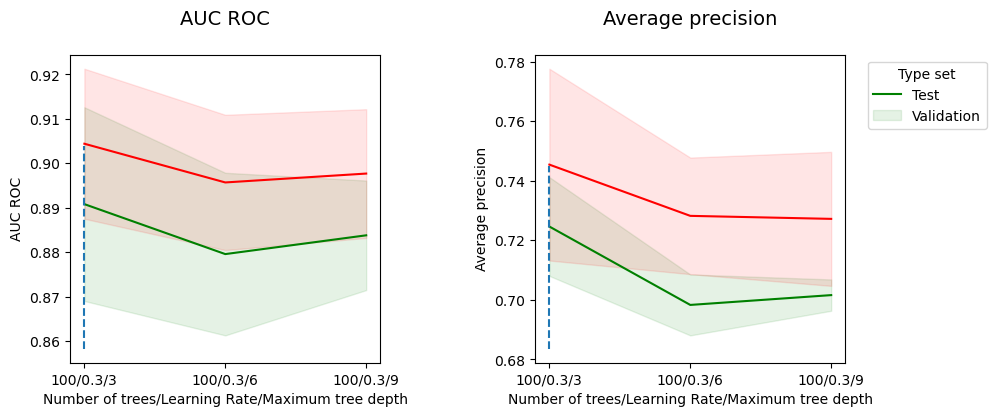

In [103]:
performances_xgboost_fixed_number_of_trees = performances_xgboost[performances_xgboost["Parameter Chosen"].str.startswith("100/0.3")]

summary_fixed_number_of_trees = get_summary_performances(performances_xgboost_fixed_number_of_trees)

get_performances_plots(performances_xgboost_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Validation'], type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Learning Rate/Maximum tree depth",
                       summary_performances=summary_fixed_number_of_trees)

Increasing the max_depth does not clearly affect the performances. It slightly increases performances for AUC ROC and AP.

Let's plot the performances as a function of the number of trees, for a max_depth set to 3, and a learning rate set to 0.3.

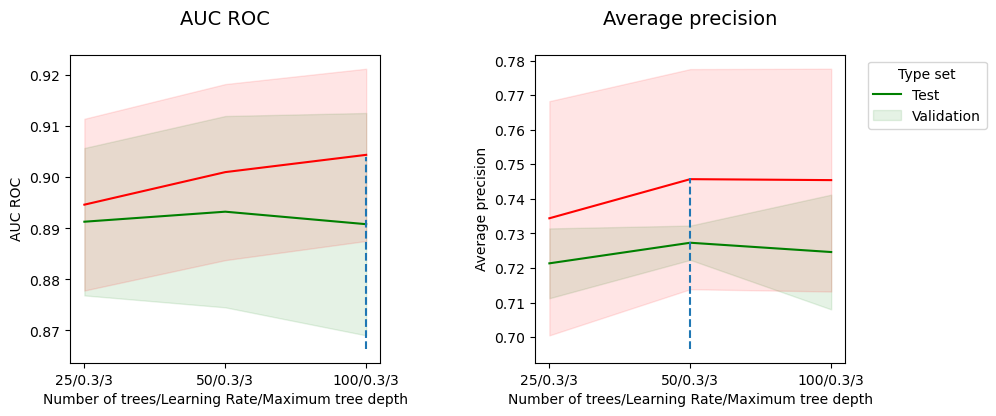

In [104]:
performances_xgboost_fixed_max_depth = performances_xgboost[performances_xgboost["Parameter Chosen"].str.endswith("0.3/3")]

summary_fixed_max_depth = get_summary_performances(performances_xgboost_fixed_max_depth)

get_performances_plots(performances_xgboost_fixed_max_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision'], 
                       type_list=['Test','Validation'], type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Learning Rate/Maximum tree depth",
                       summary_performances=summary_fixed_max_depth)

Increasing the number of trees from 25 to 50 increases both performance metrics. Adding more trees however only provides slightly higher performances for AUC ROC and AP.

#### 5.5 Comparing Models

Time to compare all previous model performances in order to pick the best model tuned with the optimal parameters.

For each model, let's retrieve and visualise the performances for 3 types of parameters:
1. Default parameters:
    - Decision Tree: `max_depth=None`
    - Logistic Regression: `C=1`
    - Random Forest: `n_estimators=100`, `max_depth=None`
    - XGBoost: `n_estimators=100`, `max_depth=6`, `learning_rate=0.3`
2. Best estimated parameters: the parameters that maximise validation performance
3. Optimal parameters: the parameters that maximise test performance

Define `model_selection_performances` function that takes a dictionary of performance dataframes and a performance metric, and retrieves those performances (mean + standard deviation)

In [105]:
performances_dictionary = {
    'Decision Tree': performances_decision_tree,
    'Logistic Regression': performances_logistic_regression,
    'Random Forest': performances_random_forest,
    'XGBoost': performances_xgboost
}

In [106]:
def model_selection_performances(performances_dictionary: dict[str, pd.DataFrame],
                                 performance_metric: str,
                                 model_classes: list[str] = ['Decision Tree',
                                                             'Logistic Regression',
                                                             'Random Forest',
                                                             'XGBoost'],
                                 default_parameters_dictionary: dict[str | int, str] = {
                                                "Decision Tree": 40,
                                                "Logistic Regression": 1,
                                                "Random Forest": "100/50",
                                                "XGBoost": "100/0.3/6"
                                            }):
    
    mean_performances_dictionary: dict[str, list[float]] = {
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    std_performances_dictionary: dict[str, list[float]] = {
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    for model_class in model_classes:
        performances = performances_dictionary[model_class]
        
        # Get the performances for the default paramaters
        default_performances: pd.Series = performances[performances['Parameter Chosen'] == default_parameters_dictionary[model_class]]
        default_performances = default_performances.round(decimals=3)
        
        mean_performances_dictionary["Default parameters"].append(default_performances[performance_metric + " Test"].values[0])
        std_performances_dictionary["Default parameters"].append(default_performances[performance_metric + " Test Std"].values[0])
        
        # Get the performances for the best estimated parameters
        summary = get_summary_performances(performances)

        # this returns the +/- value in the Test performance row for the `performance_metric` column
        mean_and_std_best_validation: str = summary.loc[["Test performance"]][performance_metric].values[0]
        mean_and_std_best_validation = mean_and_std_best_validation.split(" +/- ")

        mean_performances_dictionary["Best validation parameters"].append(float(mean_and_std_best_validation[0]))
        std_performances_dictionary["Best validation parameters"].append(float(mean_and_std_best_validation[1]))
        
        # Get the performances for the optimal parameters
        mean_and_std_optimal: str = summary.loc[["Optimal test performance"]][performance_metric].values[0]
        mean_and_std_optimal = mean_and_std_optimal.split(" +/- ")
        mean_performances_dictionary["Optimal parameters"].append(float(mean_and_std_optimal[0]))
        std_performances_dictionary["Optimal parameters"].append(float(mean_and_std_optimal[1]))
        
    # Return the mean performances and their standard deviations
    return (mean_performances_dictionary, std_performances_dictionary)

Let's try this function for the AUC ROC metric.

In [107]:
mean_perfs, std_perfs = model_selection_performances(performances_dictionary, performance_metric='AUC ROC')
print('mean performances: ', mean_perfs)
print('std: ', std_perfs)

mean performances:  {'Default parameters': [0.815, 0.891, 0.893, 0.88], 'Best validation parameters': [0.815, 0.891, 0.893, 0.891], 'Optimal parameters': [0.826, 0.891, 0.895, 0.893]}
std:  {'Default parameters': [0.006, 0.012, 0.007, 0.009], 'Best validation parameters': [0.01, 0.01, 0.01, 0.01], 'Optimal parameters': [0.01, 0.01, 0.01, 0.01]}


To visualise, I will plot the performances for the four model classes and for each performance metric as bar charts.

In [108]:
# Get the performance plot for a single performance metric
def get_model_selection_performance_plot(performances_dictionary: dict[str, pd.DataFrame],
                                         ax: np.ndarray, 
                                         performance_metric: str,
                                         ylim=[0,1],
                                         model_classes: list[str] = ['Decision Tree',
                                                                     'Logistic Regression',
                                                                     'Random Forest',
                                                                     'XGBoost']):


    (mean_performances_dictionary, std_performances_dictionary) = \
        model_selection_performances(performances_dictionary,
                                     performance_metric=performance_metric)
    
    
    # width of the bars
    barWidth = 0.3
    # The x position of bars
    r1 = np.arange(len(model_classes))
    r2 = r1 + barWidth
    r3 = r1 + 2 * barWidth
    
    # Create Default parameters bars (Orange)
    ax.bar(r1, mean_performances_dictionary['Default parameters'], 
           width = barWidth, color = '#CA8035', edgecolor = 'black', 
           yerr=std_performances_dictionary['Default parameters'], capsize=7, label='Default parameters')
 
    # Create Best validation parameters bars (Red)
    ax.bar(r2, mean_performances_dictionary['Best validation parameters'], 
           width = barWidth, color = '#008000', edgecolor = 'black', 
           yerr=std_performances_dictionary['Best validation parameters'], capsize=7, label='Best validation parameters')

    # Create Optimal parameters bars (Green)
    ax.bar(r3, mean_performances_dictionary['Optimal parameters'], 
           width = barWidth, color = '#2F4D7E', edgecolor = 'black', 
           yerr=std_performances_dictionary['Optimal parameters'], capsize=7, label='Optimal parameters')
 

    # Set title, and x and y axes labels
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xticks(r2+barWidth/2)
    ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
    ax.set_title(performance_metric+'\n', fontsize=18)
    ax.set_xlabel("Model class", fontsize=16)
    ax.set_ylabel(performance_metric, fontsize=15)


def get_model_selection_performances_plots(performances_dictionary: dict[str, pd.DataFrame], 
                                           performance_metrics_list=['AUC ROC', 'Average precision'],
                                           ylim_list=[[0.6,0.9],[0.2,0.8],[0.2,0.35]],
                                           model_classes=['Decision Tree', 
                                                          'Logistic Regression', 
                                                          'Random Forest', 
                                                          'XGBoost']):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    parameter_types=['Default parameters', 'Best validation parameters', 'Optimal parameters']
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
        get_model_selection_performance_plot(performances_dictionary, 
                                             ax[i], 
                                             performance_metrics_list[i],
                                             ylim=ylim_list[i],
                                             model_classes=model_classes
                                            )
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=parameter_types, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Parameter type",
                                       prop={'size': 12},
                                       title_fontsize=12)

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

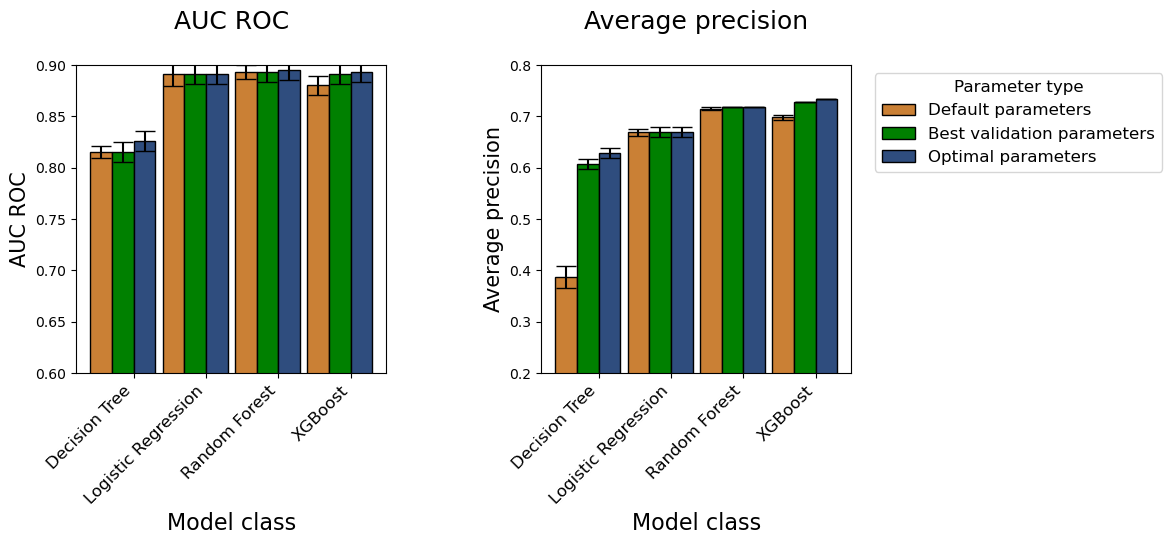

In [109]:
get_model_selection_performances_plots(performances_dictionary)

**XGBoost** has the highest performance in terms of Average Precision, followed by Random Forest, Logistic Regression, and Decision Trees, which have the lowest performance.

The performance difference is most visible with the AP metric.

The performances of Logistic Regression, Random Forest, and XGBoost are very similar in terms of AUC ROC.

Therefore, our best model for a Credit Card Fraud Detection System would be an extreme gradient boosted model (XGBoost), with the following hyperparameters set:
- n_estimators: 50
- learning_rate: 0.3
- max_depth: 3

This model achieves an an average precision of 73%, and an AUC ROC of 89%.